<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Financial Data Analyst Entry Task<br>
<font color=3C99D size=4>
    Winter 2025<br>
<font color=696880 size=5>
    AmirReza Azari

# Task 1: Data Collection, Processing, and Resampling

<p>
In this task, you will focus on acquiring and refining high-frequency OHLCV candlestick data from key
cryptocurrency exchanges. This involves creating efficient Python functions for data retrieval, transforming raw data into structured formats suitable for analysis, and resampling it to various time scales.
The goal is to ensure accuracy, handle anomalies effectively, and prepare the dataset for in-depth time
series analysis.
</p>

## 1.1 Data Collection: Fetching OHLCV Candlestick Data

In this segment, you are tasked with the retrieval and initial processing of high-frequency OHLCV
(Open, High, Low, Close, Volume) candlestick data. The data should be accurate, consistent, and cover
the specified period with the required granularity. Focus on the following cryptocurrency pairs from
their respective exchanges:
- USDT-TMN from Nobitex
- USDT-TMN from Tabdeal 
- BTC-TMN from Tabdeal
- BTC-USDT from either KuCoin or Binance

Ensure that your data collection covers the period from December 1, 2022, to December 1,
2023, with each record representing a one-minute interval. The key tasks are:
1. **Modular Python Functions for API Interactions:** Develop well-structured Python functions
that encapsulate the functionality for API interactions with exchanges. Your code should efficiently
handle data retrieval, with robust error-handling mechanisms to manage potential issues such as
API downtimes, rate limits, or data inconsistencies. Emphasize clean, readable, and reusable code
practices to ensure maintainability and scalability of the data fetching process.

2. **Processing OHLCV Data into a Representative Price Series:** Analyze and process the
raw OHLCV data to construct a representative price series for each cryptocurrency pair. You are
required to determine the most appropriate method for condensing OHLCV data into a single price
point per timestamp. Options might include selecting the ’Close’ price, calculating the average, or a
combination of OHLC values. Critically justify your chosen approach, explaining how it accurately
represents market dynamics and supports subsequent analytical tasks.

3. **Extraction of Implied USDT-TMN Price Series:** Utilize the collected BTC-TMN and BTCUSDT data to derive the implied USDT-TMN exchange rate from these two prices as our third
USDT-TMN price. In the end, we want to analyze three separate minutely price series for USDTTMN.

#### 1. Modular Python Functions for API Interactions: 
Develop well-structured Python functions
that encapsulate the functionality for API interactions with exchanges. Your code should efficiently
handle data retrieval, with robust error-handling mechanisms to manage potential issues such as
API downtimes, rate limits, or data inconsistencies. Emphasize clean, readable, and reusable code
practices to ensure maintainability and scalability of the data fetching process.



In [272]:
# Libraries
import time
import json
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro, skew, kurtosis
from statsmodels.graphics.gofplots import qqplot
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [188]:
def gregorian_to_unix(date_str):
    """
    Converts a Gregorian date string (YYYY-MM-DD) to a Unix timestamp.
    :param date_str: Date in 'YYYY-MM-DD' format.
    :return: Unix timestamp as an integer.
    """
    dt = datetime.strptime(date_str, '%Y-%m-%d')
    return int(dt.timestamp())

def fetch_stock_data(symbol, start_date, end_date, api_url):
    """
    Fetch stock data for a given symbol within the specified date range.
    :param symbol: The market symbol (e.g., 'BTCIRT').
    :param start_date: Start date in 'YYYY-MM-DD' format.
    :param end_date: End date in 'YYYY-MM-DD' format.
    :param api_url: Base URL of the API.
    :return: A pandas DataFrame containing the stock data, or None if an error occurs.
    """
    # Convert dates to Unix timestamps
    start_timestamp = gregorian_to_unix(start_date)
    end_timestamp = gregorian_to_unix(end_date)
    
    # Construct the API URL
    url = f"{api_url}?symbol={symbol}&resolution=D&from={start_timestamp}&to={end_timestamp}"
    
    try:
        # Fetch data from the API
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        # Parse the JSON response
        data = response.json()
        
        # Ensure the response has valid data
        if "t" in data and "o" in data:
            return pd.DataFrame(data, columns=["t", "o", "h", "l", "c", "v"])
        else:
            print(f"Unexpected response format for symbol {symbol}: {data}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

def process_data(symbol, start_date, end_date, api_url):
    """
    Fetch and process stock data for multiple symbols.
    :param symbols: A list of market symbols to fetch data for.
    :param start_date: Start date in 'YYYY-MM-DD' format.
    :param end_date: End date in 'YYYY-MM-DD' format.
    :param api_url: Base URL of the API.
    """
    print(f"Fetching data for {symbol}...")

    # Fetch data for the symbol
    stock_data = fetch_stock_data(symbol, start_date, end_date, api_url)

    if stock_data is not None:
        # Rename columns for readability
        stock_data.rename(
            columns={'t': 'timestamp', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'},
            inplace=True
        )
        # Convert timestamps to readable date format
        stock_data['timestamp'] = pd.to_datetime(stock_data['timestamp'], unit='s')

        print(f"Data for {symbol}:")
        print(stock_data)
        return stock_data
    else:
        print(f"No data available for {symbol}.")

In [189]:
# Testing:
# Configuration
API_URL = "https://api.nobitex.ir/market/udf/history"
SYMBOLS = {'BTCIRT', 'BTCUSDT', 'USDTIRT'}
START_DATE = "2022-12-01"
END_DATE = "2023-12-01"

# Process the data
for symbol in SYMBOLS:
    process_data(symbol, START_DATE, END_DATE, API_URL)

Fetching data for BTCUSDT...
Data for BTCUSDT:
              timestamp      open      high       low     close     volume
0   2022-11-30 20:30:00  16970.00  17200.00  16750.00  16801.73  12.799344
1   2022-12-01 20:30:00  16899.00  17075.00  16751.00  16950.00   6.088555
2   2022-12-02 20:30:00  16950.31  17192.09  16828.00  16836.48   6.355922
3   2022-12-03 20:30:00  16862.01  17132.00  16809.00  17089.89   6.716979
4   2022-12-04 20:30:00  17100.00  17400.10  16900.00  16900.00  14.941691
..                  ...       ...       ...       ...       ...        ...
360 2023-11-25 20:30:00  37730.00  37809.99  37011.00  37398.00   9.426558
361 2023-11-26 20:30:00  37498.00  37700.00  36780.00  36885.00  15.049927
362 2023-11-27 20:30:00  36980.00  38136.90  36810.19  37886.22  25.159799
363 2023-11-28 20:30:00  37900.00  38148.30  37532.50  37750.00  14.752279
364 2023-11-29 20:30:00  37783.62  37998.00  37480.00  37613.32   8.706973

[365 rows x 6 columns]
Fetching data for USDTIRT...


In [190]:
# First try for all API before realizing the incompleteness of the APIs 

# API_KEYS = {
#     "nobitex": "YOUR_NOBITEX_API_KEY",
#     "tabdeal": "YOUR_TABDEAL_API_KEY",
#     "binance": "YOUR_BINANCE_API_KEY",
#     "kucoin": "YOUR_KUCOIN_API_KEY",
# }

# API_ENDPOINTS = {
#     "nobitex": "https://api.nobitex.ir/v2/candlesticks",
#     "tabdeal": "https://api.tabdeal.org/v1/candlesticks",
#     "binance": "https://api.binance.com/api/v3/klines",
#     "kucoin": "https://api.kucoin.com/api/v1/market/candles",
# }

# START_DATE = "2022-12-01"
# END_DATE = "2023-12-01"

# ## Step 3: Define Functions for Data Collection

# def fetch_data(api_name, pair, interval="1m", start_date=START_DATE, end_date=END_DATE):
#     """Fetch OHLCV data from specified API."""
#     params = {
#         "symbol": pair,
#         "interval": interval,
#         "startTime": int(pd.Timestamp(start_date).timestamp() * 1000),
#         "endTime": int(pd.Timestamp(end_date).timestamp() * 1000),
#     }
#     response = requests.get(API_ENDPOINTS[api_name], params=params, headers={"X-API-KEY": API_KEYS[api_name]})
#     if response.status_code == 200:
#         data = response.json()
#         if api_name in ["binance", "kucoin"]:
#             data = data["data"]
#         return pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close", "volume"])
#     else:
#         print(f"Error fetching data from {api_name}: {response.text}")
#         return pd.DataFrame()

#### 2. Processing OHLCV Data into a Representative Price Series:
Analyze and process the
raw OHLCV data to construct a representative price series for each cryptocurrency pair. You are
required to determine the most appropriate method for condensing OHLCV data into a single price
point per timestamp. Options might include selecting the ’Close’ price, calculating the average, or a
combination of OHLC values. Critically justify your chosen approach, explaining how it accurately
represents market dynamics and supports subsequent analytical tasks.

<P>
  First, because csv files are not sorted and have differnet timestamps, I recognize the intersection  times between them and create new files. In other words, I delete unsynch datas in the first step.
</p>

In [191]:
# List of file paths for the 6 input CSV files
file_paths = ["btctmn_m1_nobitex.csv", "btctmn_m1_tabdeal.csv", "btctmn_m1_wallex.csv", "usdttmn_m1_nobitex.csv", "usdttmn_m1_tabdeal.csv", "usdttmn_m1_wallex.csv"]

# Function to process each DataFrame
def process_dataframe(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert the 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract date and time into separate columns
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.time
    
    return df

# Process all DataFrames and store them in a list
dataframes = [process_dataframe(file_path) for file_path in file_paths]

# Sort each DataFrame by 'datetime' and save them to new files
for idx, df in enumerate(dataframes):
    # Sort the DataFrame by 'datetime'
    df_sorted = df.sort_values(by='datetime')
    
    # Define the output file name for sorted DataFrame
    output_file_path = file_paths[idx].replace(".csv", "_sorted.csv")
    
    # Save the sorted DataFrame to a new CSV file
    df_sorted.to_csv(output_file_path, index=False)
    
    print(f"Sorted CSV saved to: {output_file_path}")

# Find common dates across all DataFrames
common_dates = set(dataframes[0]['date'])
for df in dataframes[1:]:
    common_dates = common_dates.intersection(set(df['date']))

# Sort the common dates
sorted_common_dates = sorted(common_dates)

# Save the common dates to a new CSV file
common_dates_df = pd.DataFrame(sorted_common_dates, columns=['date'])
common_dates_df.to_csv("common_dates.csv", index=False)

# Filter out rows with non-common dates, sort them by date and save to new CSV files
for idx, df in enumerate(dataframes):
    # Filter out rows where the 'date' is not in the common_dates
    df_common = df[df['date'].isin(sorted_common_dates)]
    
    # Sort the DataFrame by 'datetime' after filtering
    df_common_sorted = df_common.sort_values(by='datetime')
    
    # Define the output file name for the DataFrame with only common dates and sorted
    output_file_path_common = file_paths[idx].replace(".csv", "_common_dates_sorted.csv")
    
    # Save the DataFrame with common dates (sorted) to a new CSV file
    df_common_sorted.to_csv(output_file_path_common, index=False)
    
    print(f"Common dates sorted CSV saved to: {output_file_path_common}")


Sorted CSV saved to: btctmn_m1_nobitex_sorted.csv
Sorted CSV saved to: btctmn_m1_tabdeal_sorted.csv
Sorted CSV saved to: btctmn_m1_wallex_sorted.csv
Sorted CSV saved to: usdttmn_m1_nobitex_sorted.csv
Sorted CSV saved to: usdttmn_m1_tabdeal_sorted.csv
Sorted CSV saved to: usdttmn_m1_wallex_sorted.csv
Common dates sorted CSV saved to: btctmn_m1_nobitex_common_dates_sorted.csv
Common dates sorted CSV saved to: btctmn_m1_tabdeal_common_dates_sorted.csv
Common dates sorted CSV saved to: btctmn_m1_wallex_common_dates_sorted.csv
Common dates sorted CSV saved to: usdttmn_m1_nobitex_common_dates_sorted.csv
Common dates sorted CSV saved to: usdttmn_m1_tabdeal_common_dates_sorted.csv
Common dates sorted CSV saved to: usdttmn_m1_wallex_common_dates_sorted.csv


In [192]:
# List of file paths for the 6 input CSV files
file_paths = ["btctmn_m1_nobitex_common_dates_sorted.csv", "btctmn_m1_tabdeal_common_dates_sorted.csv", "btctmn_m1_wallex_common_dates_sorted.csv", "usdttmn_m1_nobitex_common_dates_sorted.csv",
              "usdttmn_m1_tabdeal_common_dates_sorted.csv", "usdttmn_m1_wallex_common_dates_sorted.csv"]

# Function to process each DataFrame
def process_dataframe(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure 'date' and 'time' columns exist
    if 'date' not in df.columns or 'time' not in df.columns:
        raise ValueError(f"File {file_path} must have 'date' and 'time' columns.")
    
    # Create a combined 'datetime' column
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    
    return df

# Process all DataFrames and store them in a list
dataframes = [process_dataframe(file_path) for file_path in file_paths]

# Find common datetime values across all DataFrames
common_datetimes = set(dataframes[0]['datetime'])
for df in dataframes[1:]:
    common_datetimes = common_datetimes.intersection(set(df['datetime']))

# Sort the common datetime values
sorted_common_datetimes = sorted(common_datetimes)


In [193]:
for idx, df in enumerate(dataframes):
    # Filter out rows where the 'datetime' is not in the common datetime values
    df_common = df[df['datetime'].isin(sorted_common_datetimes)]
    
    # Sort the filtered DataFrame by 'datetime'
    df_common_sorted = df_common.sort_values(by='datetime')
    
    # Define the output file name for the DataFrame with common datetime rows
    output_file_path_common = file_paths[idx].replace(".csv", "_filtered_sorted.csv")
    
    # Save the filtered and sorted DataFrame to a new CSV file
    df_common_sorted.drop(columns=['datetime'], inplace=True)  # Remove the temporary 'datetime' column
    df_common_sorted.to_csv(output_file_path_common, index=False)
    
    print(f"Filtered and sorted CSV saved to: {output_file_path_common}")

Filtered and sorted CSV saved to: btctmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv
Filtered and sorted CSV saved to: btctmn_m1_tabdeal_common_dates_sorted_filtered_sorted.csv
Filtered and sorted CSV saved to: btctmn_m1_wallex_common_dates_sorted_filtered_sorted.csv
Filtered and sorted CSV saved to: usdttmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv
Filtered and sorted CSV saved to: usdttmn_m1_tabdeal_common_dates_sorted_filtered_sorted.csv
Filtered and sorted CSV saved to: usdttmn_m1_wallex_common_dates_sorted_filtered_sorted.csv


Now, let's start processing:

In [194]:
def process_ohlcv_data(df, price_method="close"):
    """Process raw OHLCV data into representative price series."""
    if price_method == "average":
        df["price"] = df[["open", "high", "low", "close"]].mean(axis=1)
    else:
        df["price"] = df[price_method]
    return df

In [195]:
file_paths = ["btctmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv", "btctmn_m1_tabdeal_common_dates_sorted_filtered_sorted.csv", "btctmn_m1_wallex_common_dates_sorted_filtered_sorted.csv",
              "usdttmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv",
              "usdttmn_m1_tabdeal_common_dates_sorted_filtered_sorted.csv", "usdttmn_m1_wallex_common_dates_sorted_filtered_sorted.csv"]
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df = process_ohlcv_data(df)
    df.to_csv(file_path, index=False)

1. **Close Price**:
   - **Advantages**:
     - Widely used in financial analyses as it reflects the market consensus at the end of the interval.
     - Simple to use and compare across time periods.
   - **Disadvantages**:
     - May overlook intraday volatility.

2. **Average Price (OHLC)**:
   - **Formula**:
     $$
     \text{Average} = \frac{\text{Open} + \text{High} + \text{Low} + \text{Close}}{4}
    $$
   - **Advantages**:
     - Accounts for intraday price movements, giving a balanced view of market behavior.
   - **Disadvantages**:
     - Slightly harder to compare across intervals as minor fluctuations have more impact.
     
For this financial analysis:
- The **Close Price** is selected as the representative price because it is widely used for trend analysis, simple to compute, and aligns well with market dynamics.

#### 3. Extraction of Implied USDT-TMN Price Series: 
 Utilize the collected BTC-TMN and BTC-USDT data to derive the implied USDT-TMN exchange rate from these two prices as our third
USDT-TMN price. In the end, we want to analyze three separate minutely price series for USDTTMN.

In [197]:
# # Testing
API_URL = "https://api.nobitex.ir/market/udf/history"
SYMBOLS = 'BTCUSDT'
START_DATE = "2022-11-21"
END_DATE = "2024-03-09"

# Process the data
df = process_data(SYMBOLS, START_DATE, END_DATE, API_URL)
process_ohlcv_data(df)
df.to_csv('btcusdt_nobitex.csv', index=False)

Fetching data for BTCUSDT...
Data for BTCUSDT:
              timestamp      open      high       low     close     volume
0   2022-11-20 20:30:00  16545.35  16563.99  15600.00  15845.00  14.087058
1   2022-11-21 20:30:00  15839.00  16249.98  15502.00  16194.99   9.434792
2   2022-11-22 20:30:00  16194.99  16644.00  16079.00  16479.95  11.667384
3   2022-11-23 20:30:00  16479.99  16644.00  16210.03  16612.97   6.440920
4   2022-11-24 20:30:00  16599.99  16599.99  16250.00  16470.00   3.888835
..                  ...       ...       ...       ...       ...        ...
469 2024-03-03 20:30:00  62401.19  67400.00  62401.00  67000.00  68.926863
470 2024-03-04 20:30:00  66902.01  68241.52  56689.22  61450.00  75.417219
471 2024-03-05 20:30:00  61200.00  67176.99  60251.00  66300.00  54.910917
472 2024-03-06 20:30:00  66300.93  67350.00  65111.00  67200.00  36.202450
473 2024-03-07 20:30:00  67200.00  68750.00  66000.00  68301.00  43.560499

[474 rows x 6 columns]


In [198]:
print(pd.read_csv('btcusdt_nobitex.csv'))
print(pd.read_csv('btctmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv'))
print(pd.read_csv('usdttmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv'))

               timestamp      open      high       low     close     volume  \
0    2022-11-20 20:30:00  16545.35  16563.99  15600.00  15845.00  14.087058   
1    2022-11-21 20:30:00  15839.00  16249.98  15502.00  16194.99   9.434792   
2    2022-11-22 20:30:00  16194.99  16644.00  16079.00  16479.95  11.667384   
3    2022-11-23 20:30:00  16479.99  16644.00  16210.03  16612.97   6.440920   
4    2022-11-24 20:30:00  16599.99  16599.99  16250.00  16470.00   3.888835   
..                   ...       ...       ...       ...       ...        ...   
469  2024-03-03 20:30:00  62401.19  67400.00  62401.00  67000.00  68.926863   
470  2024-03-04 20:30:00  66902.01  68241.52  56689.22  61450.00  75.417219   
471  2024-03-05 20:30:00  61200.00  67176.99  60251.00  66300.00  54.910917   
472  2024-03-06 20:30:00  66300.93  67350.00  65111.00  67200.00  36.202450   
473  2024-03-07 20:30:00  67200.00  68750.00  66000.00  68301.00  43.560499   

        price  
0    15845.00  
1    16194.99  
2  

Due to limitations in the provided information and incomplete API data, only data from Nobitex could be retrieved successfully. Additionally, the datasets are not synchronized across the same time periods. 

As a result, this section is deferred for now, and we will proceed to the next steps, specifically focusing on **resampling** and subsequent analyses.

But, to compute the value we should use this formula:
$$
     \[
     \text{Implied USDT-TMN} = \frac{\text{BTC-TMN Price}}{\text{BTC-USDT Price}}
     \]
$$

## 1.2 Resampling:
In this segment of the task, you will address the challenge of transforming minutely data into various
broader time scales, suitable for both short-term and long-term analytical perspectives. This approach
to resampling is critical as it lays the foundation for all subsequent analyses.

1. **Selection of Time Scales**: Resample the minutely data into time frames of 5, 20, 60, and
1440 minutes. These time scales have been chosen to provide insights into intra-day, daily, and
longer-term market trends.
2. **Methodological Approach**: You are required to select and implement an appropriate resampling
method for each time scale. Possible methods include Time-Weighted Average Price (TWAP),
Volume-Weighted Average Price (VWAP), or simply using the last recorded price within each time
frame. It is imperative that you provide a detailed justification for your choice of method, focusing
on its ability to preserve the essential characteristics of the financial data.


#### Why VWAP?
Volume-Weighted Average Price (VWAP) is a robust method for resampling financial data because it accounts for both price and trading volume within a given time frame. This approach ensures that larger trades have a greater impact on the resulting average price, accurately reflecting market dynamics.

#### Advantages of VWAP:
1. **Volume Sensitivity**:
   - VWAP gives higher weight to prices associated with higher trading volumes. This makes it particularly useful for understanding the true average price at which most trades occurred.
   
2. **Preserving Market Dynamics**:
   - Compared to simple averages or closing prices, VWAP captures the interaction between price and trading activity, providing a more comprehensive view of market behavior.

3. **Analytical Utility**:
   - Many trading strategies rely on VWAP to measure liquidity and execution quality, making it a widely accepted standard in financial analysis.

#### Comparison with Other Methods:
- **Closing Price**:
  - Only represents the price at the end of the interval, ignoring intraday fluctuations and trading activity.
- **Arithmetic Average (OHLC)**:
  - Considers price movements but ignores the impact of volume, leading to less reliable insights in high-volume markets.

#### Conclusion:
VWAP is chosen as the resampling method because it accurately reflects both price trends and trading activity. This makes it ideal for analyzing financial datasets like USD-TMN and BTC-USDT, where understanding true trading behavior is essential.


#### 1&2 . Selection of Time Scales & Methodological Approach

In [199]:
def resample_with_vwap_fast(df, scale):
    """
    Resample the data into specified time frames using Volume-Weighted Average Price (VWAP).

    Parameters:
    - df: DataFrame with columns ['price', 'volume', 'date', 'time']
    - scale: Resampling time frame in minutes (e.g., 5, 20, 60, 1440)

    Returns:
    - Resampled DataFrame with VWAP values for each time frame.
    """
    # Combine date and time into a single timestamp column
    df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'])

    # Align timestamps to the nearest scale boundary
    df['aligned_timestamp'] = df['timestamp'].dt.floor(f'{scale}T')

    # Group by aligned timestamps
    grouped = df.groupby('aligned_timestamp')

    # Calculate VWAP for each group
    price_volume = grouped.apply(lambda x: (x['price'] * x['volume']).sum())
    volume_sum = grouped['volume'].sum()

    # Compute VWAP
    vwap = (price_volume / volume_sum).reset_index(name='price')

    return vwap

In [221]:
# Example:
dataframes = {}

# Process each file
for file_path in file_paths:
    # Create a dictionary key based on the file name
    key = file_path.split("_common")[0].replace("m1_", "").replace("_", " ").title().replace(" ", "_")
    df = pd.read_csv(file_path)
    df = resample_with_vwap_fast(df, 720)
    dataframes[key] = df
    
    # Print the result
    print(f"Resampled {key}:")
    print(df)

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Resampled Btctmn_Nobitex:
      aligned_timestamp         price
0   2022-11-20 12:00:00  5.920026e+08
1   2022-11-21 00:00:00  5.803889e+08
2   2022-11-21 12:00:00  5.762059e+08
3   2022-11-22 00:00:00  5.687699e+08
4   2022-11-22 12:00:00  5.753146e+08
..                  ...           ...
946 2024-03-07 12:00:00  3.993376e+09
947 2024-03-08 00:00:00  4.011728e+09
948 2024-03-08 12:00:00  4.050360e+09
949 2024-03-09 00:00:00  4.069125e+09
950 2024-03-09 12:00:00  4.063603e+09

[951 rows x 2 columns]


C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Resampled Btctmn_Tabdeal:
      aligned_timestamp         price
0   2022-11-20 12:00:00  5.930236e+08
1   2022-11-21 00:00:00  5.824828e+08
2   2022-11-21 12:00:00  5.782331e+08
3   2022-11-22 00:00:00  5.691146e+08
4   2022-11-22 12:00:00  5.749555e+08
..                  ...           ...
946 2024-03-07 12:00:00  4.035185e+09
947 2024-03-08 00:00:00  4.019874e+09
948 2024-03-08 12:00:00  4.074608e+09
949 2024-03-09 00:00:00  4.108240e+09
950 2024-03-09 12:00:00  4.093517e+09

[951 rows x 2 columns]


C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Resampled Btctmn_Wallex:
      aligned_timestamp         price
0   2022-11-20 12:00:00  5.918509e+08
1   2022-11-21 00:00:00  5.816400e+08
2   2022-11-21 12:00:00  5.748470e+08
3   2022-11-22 00:00:00  5.687693e+08
4   2022-11-22 12:00:00  5.755617e+08
..                  ...           ...
946 2024-03-07 12:00:00  4.040018e+09
947 2024-03-08 00:00:00  4.043233e+09
948 2024-03-08 12:00:00  4.080988e+09
949 2024-03-09 00:00:00  4.103736e+09
950 2024-03-09 12:00:00  4.096311e+09

[951 rows x 2 columns]


C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Resampled Usdttmn_Nobitex:
      aligned_timestamp         price
0   2022-11-20 12:00:00  35807.831040
1   2022-11-21 00:00:00  35978.890073
2   2022-11-21 12:00:00  36050.336718
3   2022-11-22 00:00:00  36040.123363
4   2022-11-22 12:00:00  35957.663098
..                  ...           ...
946 2024-03-07 12:00:00  60064.049128
947 2024-03-08 00:00:00  60018.419171
948 2024-03-08 12:00:00  59914.537787
949 2024-03-09 00:00:00  59818.613340
950 2024-03-09 12:00:00  59920.862525

[951 rows x 2 columns]


C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Resampled Usdttmn_Tabdeal:
      aligned_timestamp         price
0   2022-11-20 12:00:00  35774.698041
1   2022-11-21 00:00:00  35913.998890
2   2022-11-21 12:00:00  35983.323945
3   2022-11-22 00:00:00  36099.646190
4   2022-11-22 12:00:00  36016.808120
..                  ...           ...
946 2024-03-07 12:00:00  60323.889660
947 2024-03-08 00:00:00  60195.124802
948 2024-03-08 12:00:00  60027.307344
949 2024-03-09 00:00:00  59946.979609
950 2024-03-09 12:00:00  60099.557156

[951 rows x 2 columns]


C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



Resampled Usdttmn_Wallex:
      aligned_timestamp         price
0   2022-11-20 12:00:00  35826.016148
1   2022-11-21 00:00:00  36004.963041
2   2022-11-21 12:00:00  36087.945494
3   2022-11-22 00:00:00  36059.038363
4   2022-11-22 12:00:00  35973.162026
..                  ...           ...
946 2024-03-07 12:00:00  60218.846745
947 2024-03-08 00:00:00  60008.084387
948 2024-03-08 12:00:00  59878.468442
949 2024-03-09 00:00:00  59907.179472
950 2024-03-09 12:00:00  60161.618668

[951 rows x 2 columns]


C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4143288035.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [222]:
print(dataframes.keys())  # List all keys in the dictionary

dict_keys(['Btctmn_Nobitex', 'Btctmn_Tabdeal', 'Btctmn_Wallex', 'Usdttmn_Nobitex', 'Usdttmn_Tabdeal', 'Usdttmn_Wallex'])


## 1.3 Handling Market Anomalies:
Effective management of market anomalies is essential for the integrity of your analysis. Your task
includes identifying and addressing missing data and outliers in a straightforward yet effective manner.

#### 1. Missing Data:
Implement a basic strategy for filling gaps in the dataset. Options include carrying
forward the last known value or using a simple average of adjacent data points. Your approach
should be appropriate for the time scales involved and should maintain the continuity of the data
series.


In [223]:
def handle_missing_data(df):
    """Fill missing data by forward fill method."""
    return df.ffill()

#### 2. Outlier Detection and Correction:
Identify significant outliers using basic statistical methods
(e.g., z-scores or box plot derived outliers). Address these outliers (if any) by either adjusting them
to a more representative value or excluding them from the dataset, depending on their impact on
overall data integrity.


In [224]:
def detect_and_correct_outliers(df, z_thresh=3):
    """Detect and handle outliers using z-scores."""
    z_scores = (df["price"] - df["price"].mean()) / df["price"].std()
    df["price"] = np.where(np.abs(z_scores) > z_thresh, np.nan, df["price"])
    return handle_missing_data(df)

In [225]:
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    processed_df = detect_and_correct_outliers(df)
    dataframes[key] = processed_df
print(dataframes)

Processing DataFrame for: Btctmn_Nobitex
Processing DataFrame for: Btctmn_Tabdeal
Processing DataFrame for: Btctmn_Wallex
Processing DataFrame for: Usdttmn_Nobitex
Processing DataFrame for: Usdttmn_Tabdeal
Processing DataFrame for: Usdttmn_Wallex
{'Btctmn_Nobitex':       aligned_timestamp         price
0   2022-11-20 12:00:00  5.920026e+08
1   2022-11-21 00:00:00  5.803889e+08
2   2022-11-21 12:00:00  5.762059e+08
3   2022-11-22 00:00:00  5.687699e+08
4   2022-11-22 12:00:00  5.753146e+08
..                  ...           ...
946 2024-03-07 12:00:00  3.366833e+09
947 2024-03-08 00:00:00  3.366833e+09
948 2024-03-08 12:00:00  3.366833e+09
949 2024-03-09 00:00:00  3.366833e+09
950 2024-03-09 12:00:00  3.366833e+09

[951 rows x 2 columns], 'Btctmn_Tabdeal':       aligned_timestamp         price
0   2022-11-20 12:00:00  5.930236e+08
1   2022-11-21 00:00:00  5.824828e+08
2   2022-11-21 12:00:00  5.782331e+08
3   2022-11-22 00:00:00  5.691146e+08
4   2022-11-22 12:00:00  5.749555e+08
..     

#### 3. Data Integrity Assurance:
Clearly describe how your methods for handling anomalies preserve
the overall quality and reliability of the data. Ensure that the measures taken are simple yet
effective in maintaining the true representation of market dynamics.


The methods used in the code ensure data integrity and reliability by handling anomalies (outliers and missing data) in a straightforward, effective way.

###### 1. Outlier Detection:
- **Z-Score**: We calculate the Z-Score for each price. If the Z-Score exceeds a certain threshold (`z_thresh`), the value is considered an outlier and replaced with `NaN`.
- **Why it works**: Removing outliers ensures that extreme, unrealistic values don't skew the analysis and the data accurately reflects real market trends.

###### 2. Handling Missing Data:
- **Forward Fill (ffill)**: Missing values (NaN) are filled with the previous non-missing value in the column.
- **Why it works**: This method keeps the data consistent, assuming market prices change gradually over time, without introducing random or incorrect values.

###### 3. Simple Yet Effective:
- The techniques used are simple to understand and implement (Z-Score for outliers, forward fill for missing values).
- They maintain the quality of the data and preserve the true representation of market dynamics.


# Task 2:  Exploratory Data Analysis (EDA):
In Task 2, you’ll conduct an in-depth Exploratory Data Analysis (EDA) focusing on key aspects of financial data. This task encompasses the calculation and assessment of log returns and volatility, including
a critical examination of their normality, as well as a detailed analysis of autocorrelation and stationarity within financial time series. Additionally, you’ll engage in an inter-market analysis to uncover and
understand the cross-correlation of log returns across different exchanges, both synchronously and with
lagged effects. These analyses are fundamental for developing robust financial models and informing
strategic trading decisions.
Important Notes:
- Price Series Analysis: You will work with three distinct USDT-TMN price series. Analyze each
series individually, and also perform pairwise analyses for all three possible pair combinations of
these price series.
- Multiple Time Scales: Recall that the data has been resampled into three different time scales.
Ensure that each analysis, both single and pairwise, is conducted on each of these time scales,
allowing for a comprehensive understanding of market behavior across different time frames.
- Strategic Use of Visualizations: The effective integration of visualizations is vital for this
analysis. It is your responsibility to discern and judiciously determine where visualizations are most
impactful. Employ Plotly to create insightful, relevant, compact, and visually compelling charts,
carefully selecting the appropriate chart types for each aspect of your analysis. Visualizations
should not be used indiscriminately but should be strategically placed to enhance understanding
and to communicate your findings in a clear and effective manner.



## 2.1 Log Returns, Volatility, and Normality Assessment:
In this section, you will delve into the quantitative analysis of financial data by calculating log returns
and assessing volatility using the EWMA model. This includes analyzing volatility clustering and performing comprehensive statistical analyses to understand distributional characteristics. A key part of
this assessment is evaluating the normality of log returns through graphical and statistical methods,
discussing their significance in the context of financial modeling and the challenges posed by non-normal
distributions.


In [226]:
# Function to calculate log returns
def calculate_log_returns(df):
    """Calculate log returns for a price series."""
    df["log_return"] = np.log(df["price"] / df["price"].shift(1))
    return df

In [227]:
# Example:
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    processed_df = calculate_log_returns(df)
    dataframes[key] = processed_df
print(dataframes)

Processing DataFrame for: Btctmn_Nobitex
Processing DataFrame for: Btctmn_Tabdeal
Processing DataFrame for: Btctmn_Wallex
Processing DataFrame for: Usdttmn_Nobitex
Processing DataFrame for: Usdttmn_Tabdeal
Processing DataFrame for: Usdttmn_Wallex
{'Btctmn_Nobitex':       aligned_timestamp         price  log_return
0   2022-11-20 12:00:00  5.920026e+08         NaN
1   2022-11-21 00:00:00  5.803889e+08   -0.019813
2   2022-11-21 12:00:00  5.762059e+08   -0.007233
3   2022-11-22 00:00:00  5.687699e+08   -0.012989
4   2022-11-22 12:00:00  5.753146e+08    0.011441
..                  ...           ...         ...
946 2024-03-07 12:00:00  3.366833e+09    0.000000
947 2024-03-08 00:00:00  3.366833e+09    0.000000
948 2024-03-08 12:00:00  3.366833e+09    0.000000
949 2024-03-09 00:00:00  3.366833e+09    0.000000
950 2024-03-09 12:00:00  3.366833e+09    0.000000

[951 rows x 3 columns], 'Btctmn_Tabdeal':       aligned_timestamp         price  log_return
0   2022-11-20 12:00:00  5.930236e+08    

In [228]:
# Function to calculate volatility using EWMA model
def volatility_analysis(df, span=30):
    """Analyze volatility using EWMA (Exponentially Weighted Moving Average)."""
    df["volatility"] = df["log_return"].ewm(span=span).std()
    return df

In [229]:
# Example:
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    processed_df = volatility_analysis(df)
    dataframes[key] = processed_df

print("###############################")
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    processed_df = detect_and_correct_outliers(df)
    processed_df['price'].fillna(processed_df['price'].mean(), inplace=True)  # Fill with mean
    processed_df['volatility'].fillna(processed_df['volatility'].mean(), inplace=True)  # Fill with mean
    dataframes[key] = processed_df
    
print(dataframes)

Processing DataFrame for: Btctmn_Nobitex
Processing DataFrame for: Btctmn_Tabdeal
Processing DataFrame for: Btctmn_Wallex
Processing DataFrame for: Usdttmn_Nobitex
Processing DataFrame for: Usdttmn_Tabdeal
Processing DataFrame for: Usdttmn_Wallex
###############################
Processing DataFrame for: Btctmn_Nobitex
Processing DataFrame for: Btctmn_Tabdeal
Processing DataFrame for: Btctmn_Wallex
Processing DataFrame for: Usdttmn_Nobitex
Processing DataFrame for: Usdttmn_Tabdeal
Processing DataFrame for: Usdttmn_Wallex
{'Btctmn_Nobitex':       aligned_timestamp         price  log_return  volatility
0   2022-11-20 12:00:00  5.920026e+08         NaN    0.011877
1   2022-11-21 00:00:00  5.803889e+08   -0.019813    0.011877
2   2022-11-21 12:00:00  5.762059e+08   -0.007233    0.008895
3   2022-11-22 00:00:00  5.687699e+08   -0.012989    0.006187
4   2022-11-22 12:00:00  5.753146e+08    0.011441    0.013658
..                  ...           ...         ...         ...
946 2024-03-07 12:00:

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4107143450.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/4107143450.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [230]:
# Function to generate descriptive statistics
def descriptive_statistics(df):
    """Generate descriptive statistics for log returns and volatility."""
    log_returns = df["log_return"].dropna()
    volatility = df["volatility"].dropna()
    
    log_returns_summary = log_returns.describe()
    volatility_summary = volatility.describe()

    # Skewness and kurtosis
    log_returns_skewness = skew(log_returns)
    log_returns_kurtosis = kurtosis(log_returns)
    
    print("Log Returns Descriptive Statistics:")
    print(log_returns_summary)
    print(f"Skewness: {log_returns_skewness}, Kurtosis: {log_returns_kurtosis}")
    
    print("\nVolatility Descriptive Statistics:")
    print(volatility_summary)

    return log_returns_summary, volatility_summary, log_returns_skewness, log_returns_kurtosis

In [231]:
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    processed_df = descriptive_statistics(df)

Processing DataFrame for: Btctmn_Nobitex
Log Returns Descriptive Statistics:
count    950.000000
mean       0.001830
std        0.013000
min       -0.052846
25%       -0.004368
50%        0.000456
75%        0.006659
max        0.069740
Name: log_return, dtype: float64
Skewness: 0.781406415201665, Kurtosis: 5.02793197044592

Volatility Descriptive Statistics:
count    951.000000
mean       0.011877
std        0.004592
min        0.004917
25%        0.008993
50%        0.011188
75%        0.013496
max        0.037922
Name: volatility, dtype: float64
Processing DataFrame for: Btctmn_Tabdeal
Log Returns Descriptive Statistics:
count    950.000000
mean       0.001835
std        0.013580
min       -0.058419
25%       -0.004268
50%        0.000513
75%        0.007093
max        0.077148
Name: log_return, dtype: float64
Skewness: 0.7841329519673644, Kurtosis: 5.388951303879725

Volatility Descriptive Statistics:
count    951.000000
mean       0.012448
std        0.004776
min        0.005328
2

In [232]:
# Function to perform graphical normality tests using Q-Q plot
def normality_qqplot(df):
    """Generate a Q-Q plot to visually inspect the normality of log returns."""
    log_returns = df["log_return"].dropna()
    qqplot(log_returns, line='s')
    plt.title("Q-Q Plot of Log Returns")
    plt.show()

Processing DataFrame for: Btctmn_Nobitex


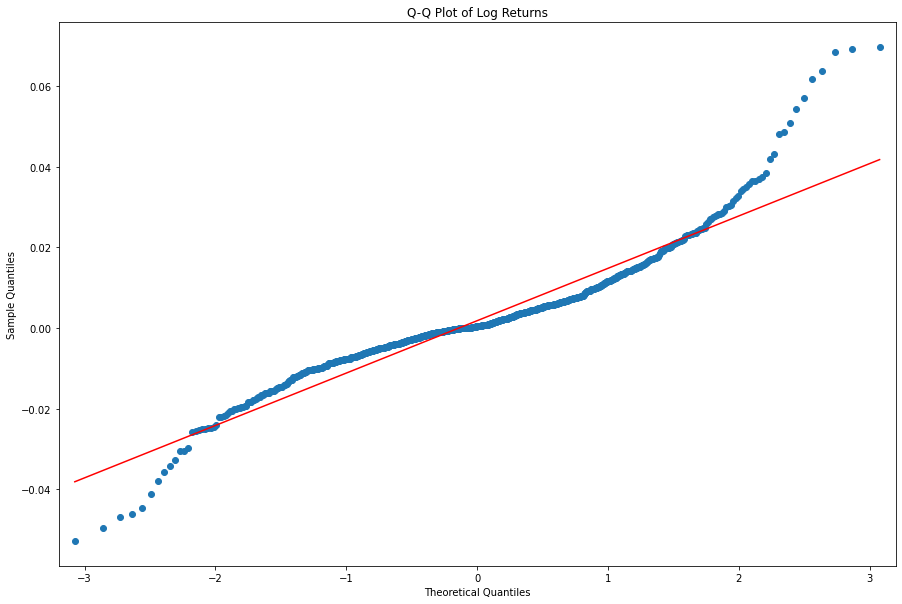

Processing DataFrame for: Btctmn_Tabdeal


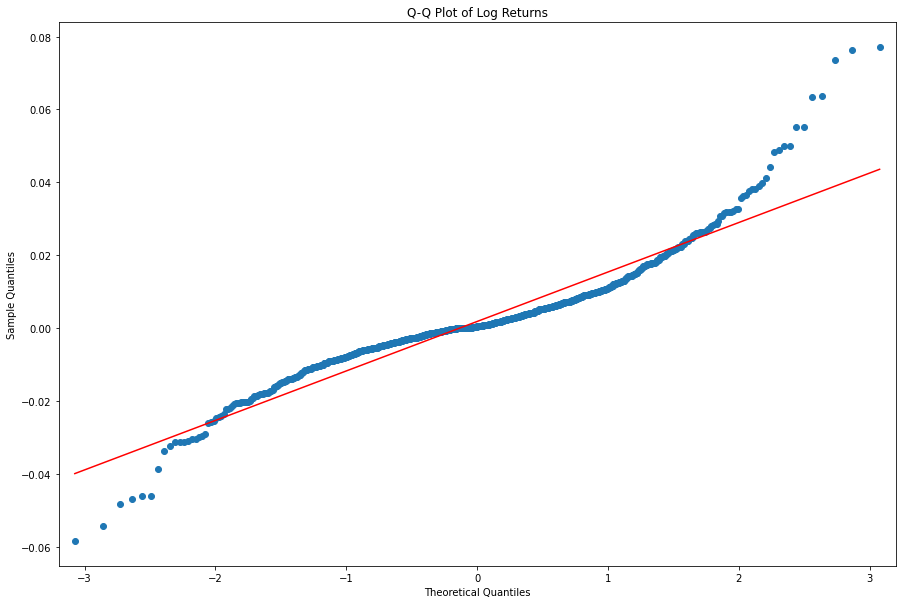

Processing DataFrame for: Btctmn_Wallex


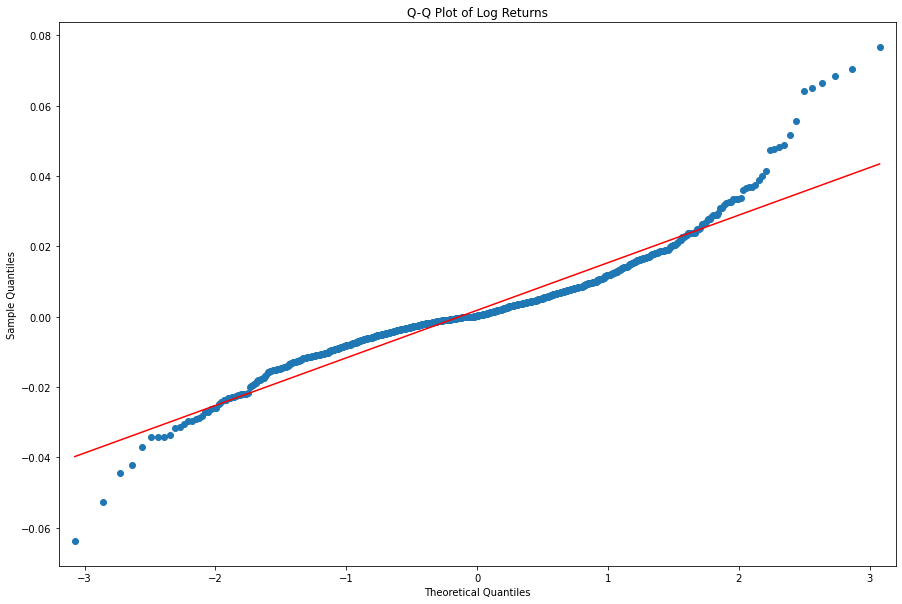

Processing DataFrame for: Usdttmn_Nobitex


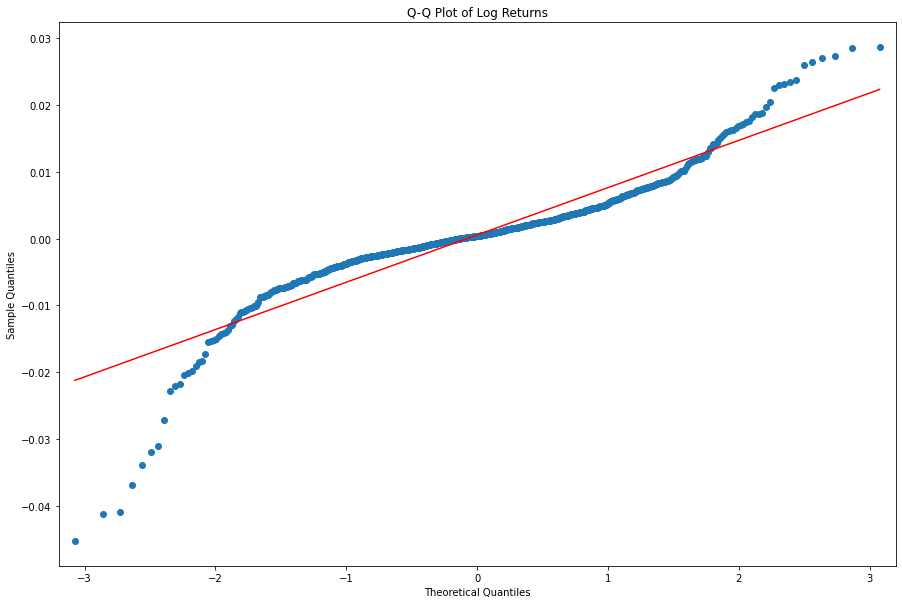

Processing DataFrame for: Usdttmn_Tabdeal


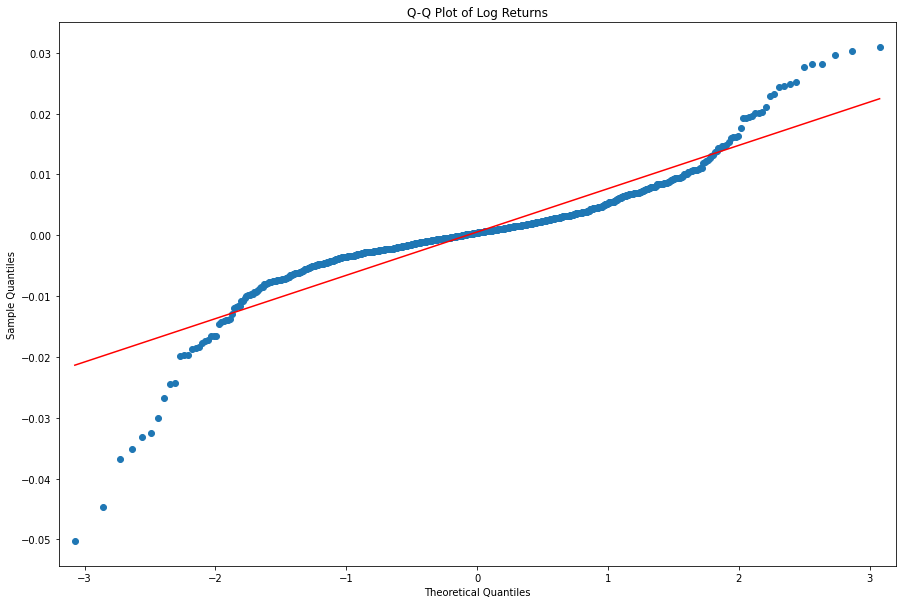

Processing DataFrame for: Usdttmn_Wallex


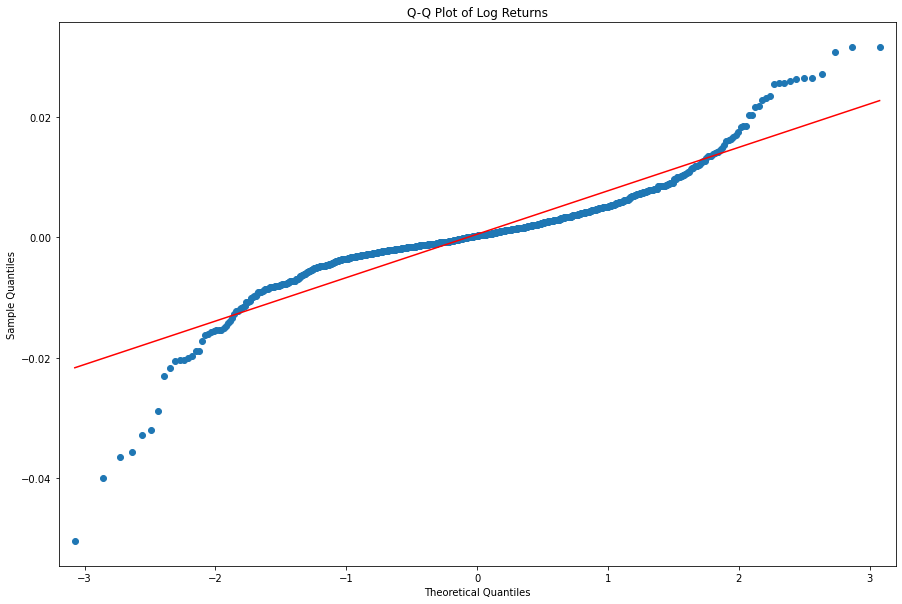

In [233]:
plt.rcParams["figure.figsize"] = (15, 10)

for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    normality_qqplot(df)

In [234]:
# Function to perform the Shapiro-Wilk test for normality
def normality_tests(df):
    """Perform normality tests on log returns."""
    log_returns = df["log_return"].dropna()
    shapiro_test = shapiro(log_returns)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    return shapiro_test

In [235]:
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    normality_tests(df)

Processing DataFrame for: Btctmn_Nobitex
Shapiro-Wilk Test: Statistic=0.9151899814605713, p-value=1.2545732078805228e-22
Processing DataFrame for: Btctmn_Tabdeal
Shapiro-Wilk Test: Statistic=0.9095292091369629, p-value=2.5826766456076755e-23
Processing DataFrame for: Btctmn_Wallex
Shapiro-Wilk Test: Statistic=0.9165634512901306, p-value=1.8629843898427628e-22
Processing DataFrame for: Usdttmn_Nobitex
Shapiro-Wilk Test: Statistic=0.8733540773391724, p-value=4.586147257905338e-27
Processing DataFrame for: Usdttmn_Tabdeal
Shapiro-Wilk Test: Statistic=0.8554790616035461, p-value=1.2822434717029465e-28
Processing DataFrame for: Usdttmn_Wallex
Shapiro-Wilk Test: Statistic=0.8674596548080444, p-value=1.3532020012397123e-27


In [245]:
def visualize_volatility_clustering(df):
    """Visualize volatility clustering."""
    fig = px.line(df, x=df.index, y="volatility", title="Volatility Clustering over Time")
    fig.show()

# Function to calculate pairwise correlation of log returns across different price series
def pairwise_correlation(df1, df2, key1, key2):
    """
    Calculate and visualize the pairwise correlation of log returns between two datasets.
    
    Args:
        df1 (DataFrame): The first dataset.
        df2 (DataFrame): The second dataset.
        key1 (str): The name/key of the first dataset (used for labeling and visualization).
        key2 (str): The name/key of the second dataset (used for labeling and visualization).
    """
    # Calculate log returns for both datasets
    df1 = calculate_log_returns(df1)
    df2 = calculate_log_returns(df2)
    
    # Compute the correlation between the log returns
    log_return_corr = df1["log_return"].corr(df2["log_return"])
    print(f"Pairwise Log Return Correlation between {key1} and {key2}: {log_return_corr}")

    # Visualization: Scatter plot of log returns for the two datasets
    fig = px.scatter(x=df1["log_return"], y=df2["log_return"], 
                     labels={'x': f'Log Return ({key1})', 'y': f'Log Return ({key2})'}, 
                     title=f"Pairwise Log Return Correlation: {key1} vs {key2}")
    fig.show()


# Function to analyze stationarity (ADF test) for log returns
def stationarity_test(df):
    """Perform ADF test to check stationarity of log returns."""
    log_returns = df["log_return"].dropna()
    adf_test = adfuller(log_returns)
    print(f"ADF Test: Statistic={adf_test[0]}, p-value={adf_test[1]}")
    return adf_test

In [241]:
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")
    visualize_volatility_clustering(df)
    stationarity_test(df)

Processing DataFrame for: Btctmn_Nobitex


ADF Test: Statistic=-7.35374607096538, p-value=9.903888725632419e-11
Processing DataFrame for: Btctmn_Tabdeal


ADF Test: Statistic=-14.544040830656076, p-value=5.090909697073038e-27
Processing DataFrame for: Btctmn_Wallex


ADF Test: Statistic=-14.302226218949148, p-value=1.2235475690322493e-26
Processing DataFrame for: Usdttmn_Nobitex


ADF Test: Statistic=-7.66369626367316, p-value=1.662645839877684e-11
Processing DataFrame for: Usdttmn_Tabdeal


ADF Test: Statistic=-6.59488453424772, p-value=6.965569352899395e-09
Processing DataFrame for: Usdttmn_Wallex


ADF Test: Statistic=-6.639371737360351, p-value=5.458911739211023e-09


In [247]:
btctmn_keys = [key for key in dataframes.keys() if key.startswith('Btctmn')]
usdttmn_keys = [key for key in dataframes.keys() if key.startswith('Usdttmn')]

btctmn_pairs = list(combinations(btctmn_keys, 2))
usdttmn_pairs = list(combinations(usdttmn_keys, 2))

for key1, key2 in btctmn_pairs:
    result = pairwise_correlation(dataframes[key1], dataframes[key2], key1, key2)
    
for key1, key2 in usdttmn_pairs:
    result = pairwise_correlation(dataframes[key1], dataframes[key2], key1, key2)

Pairwise Log Return Correlation between Btctmn_Nobitex and Btctmn_Tabdeal: 0.940327390734886


Pairwise Log Return Correlation between Btctmn_Nobitex and Btctmn_Wallex: 0.9708058529850452


Pairwise Log Return Correlation between Btctmn_Tabdeal and Btctmn_Wallex: 0.9516129010003035


Pairwise Log Return Correlation between Usdttmn_Nobitex and Usdttmn_Tabdeal: 0.9561444528993851


Pairwise Log Return Correlation between Usdttmn_Nobitex and Usdttmn_Wallex: 0.964324607005893


Pairwise Log Return Correlation between Usdttmn_Tabdeal and Usdttmn_Wallex: 0.9591968521920957


The normal distribution is crucial in financial modeling and risk assessment due to its simplicity and mathematical ease. It enables efficient risk evaluation, portfolio optimization, and derivative pricing. However, financial data often exhibit non-normal characteristics such as fat tails, skewness, and volatility clustering, which challenge the assumption of normality. These deviations can lead to underestimation of risk, inaccurate asset pricing, and poor decision-making. To address these issues, alternative models like fat-tail distributions, GARCH for volatility, and non-parametric methods can provide more accurate risk assessments and improve financial strategies.


## 2.2 Autocorrelation and Stationarity Analysis:
In this analysis, you will explore the fundamental aspects of time series data — autocorrelation and stationarity. By generating ACF and PACF plots, you will investigate the underlying temporal dependencies
in price, log returns, and volatility. Complementing this, stationarity tests will assess the stability of
these time series. The goal is to understand how autocorrelation and non-stationarity interact, shaping
the approach to model building and forecasting in financial markets.
1. ACF and PACF Plots: Generate and analyze Autocorrelation Function (ACF) and Partial
Autocorrelation Function (PACF) plots for price series, log returns, and volatility measures. Use
these plots to examine the temporal dependencies and the degree of persistence in market trends.
2. Stationarity Testing: Conduct stationarity tests, like the Augmented Dickey-Fuller (ADF) test,
on price series, log returns, and volatility to confirm the constancy of statistical properties over
time.
3. Interplay of Non-Stationarity and Autocorrelation: Examine how non-stationarity and autocorrelation in financial time series are interrelated and critical for effective modeling. Discuss the
implications of these properties for predictive modeling and strategy development, particularly how
non-stationary data, often exhibiting autocorrelation, may necessitate transformations to capture
and accurately forecast market behaviors.


Processing DataFrame for: Btctmn_Nobitex


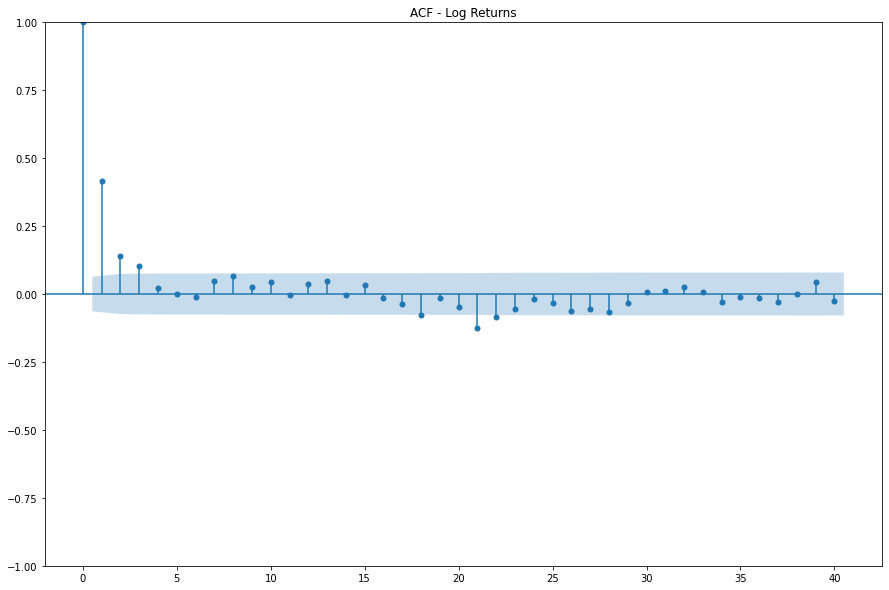

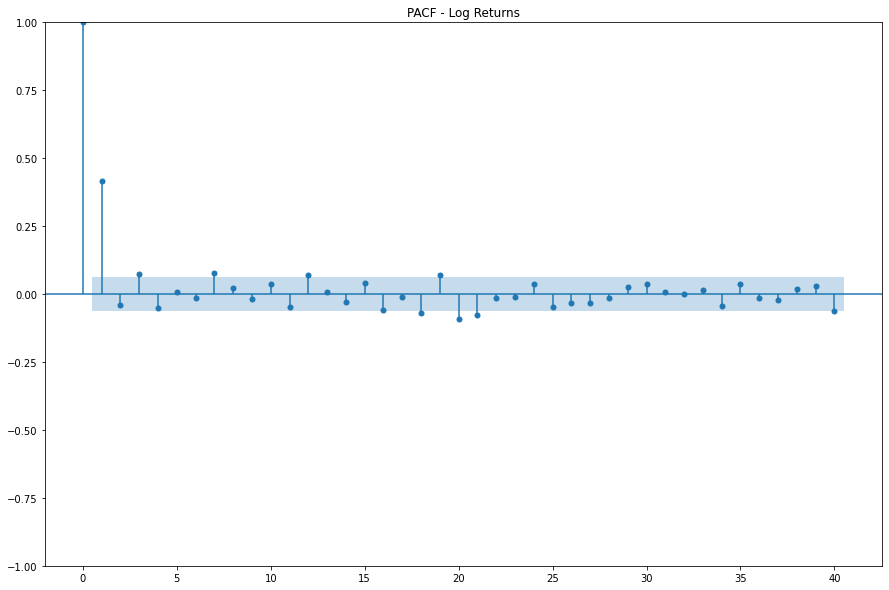

Processing DataFrame for: Btctmn_Tabdeal


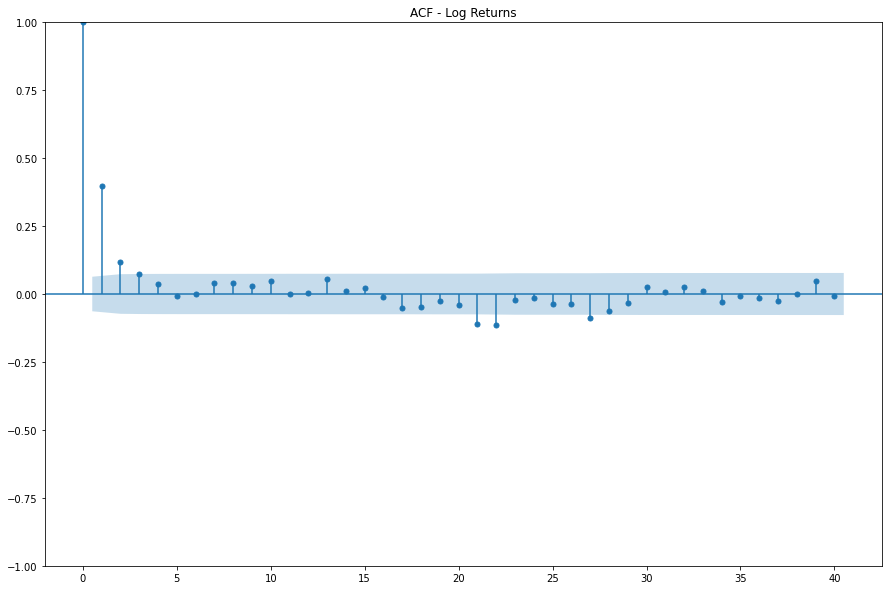

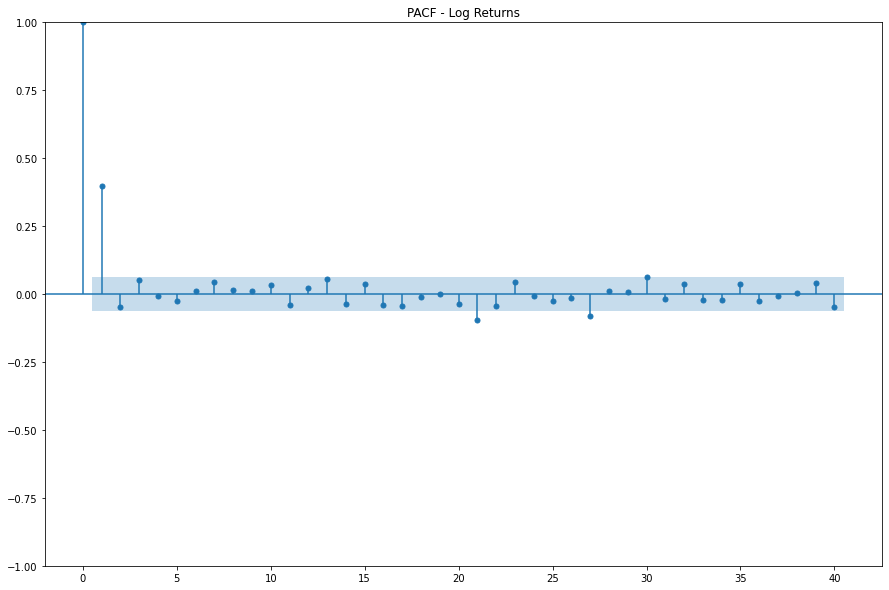

Processing DataFrame for: Btctmn_Wallex


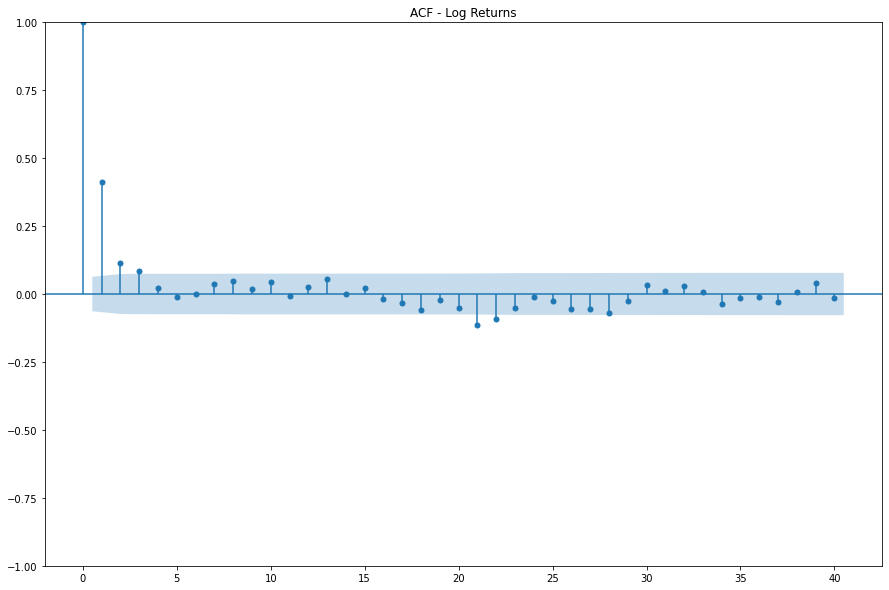

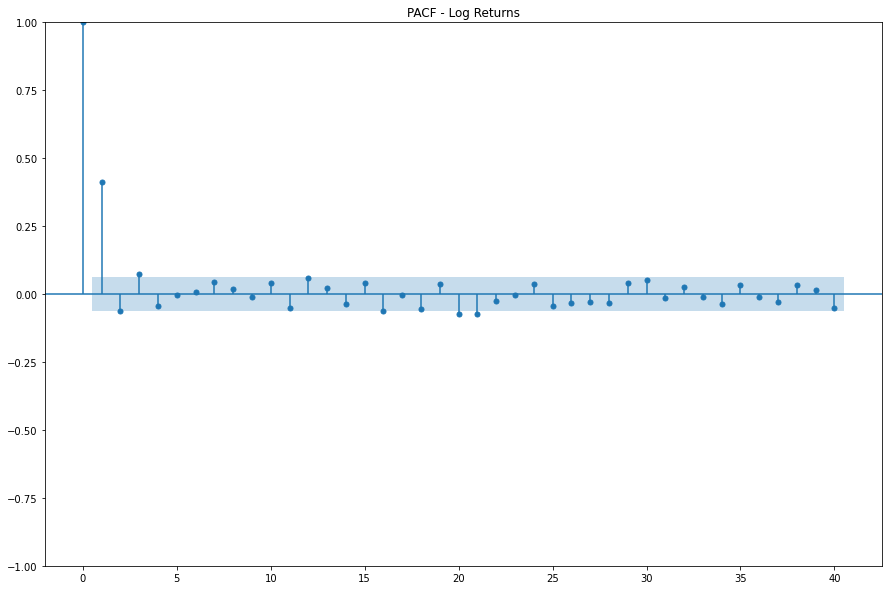

Processing DataFrame for: Usdttmn_Nobitex


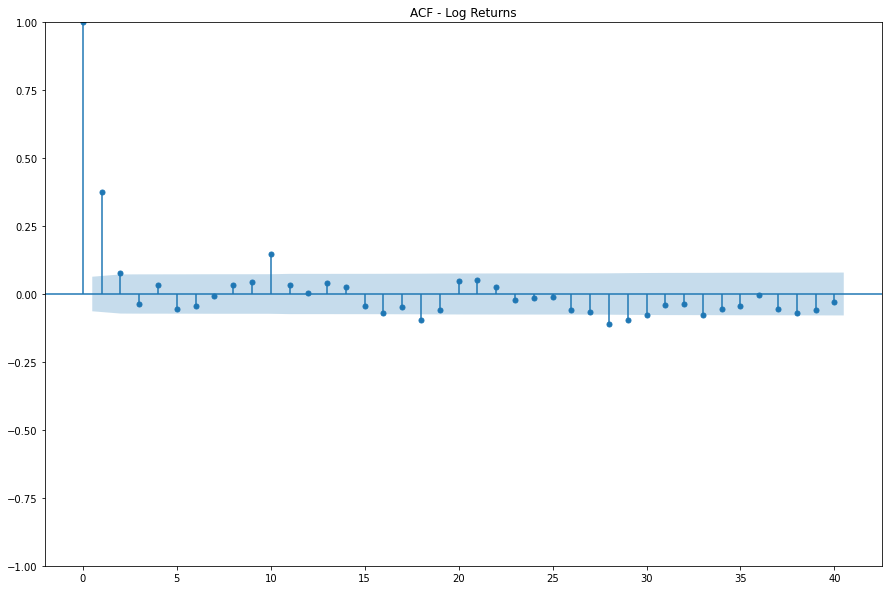

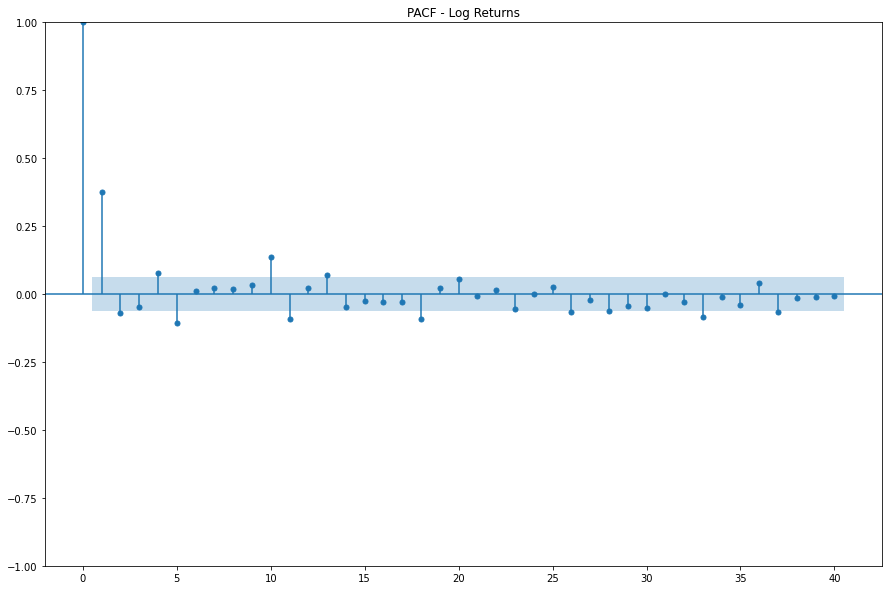

Processing DataFrame for: Usdttmn_Tabdeal


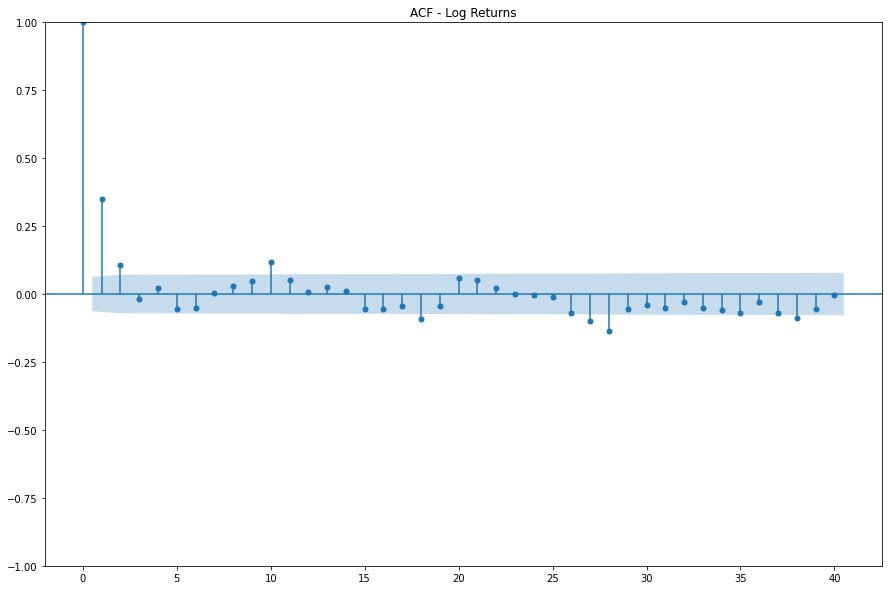

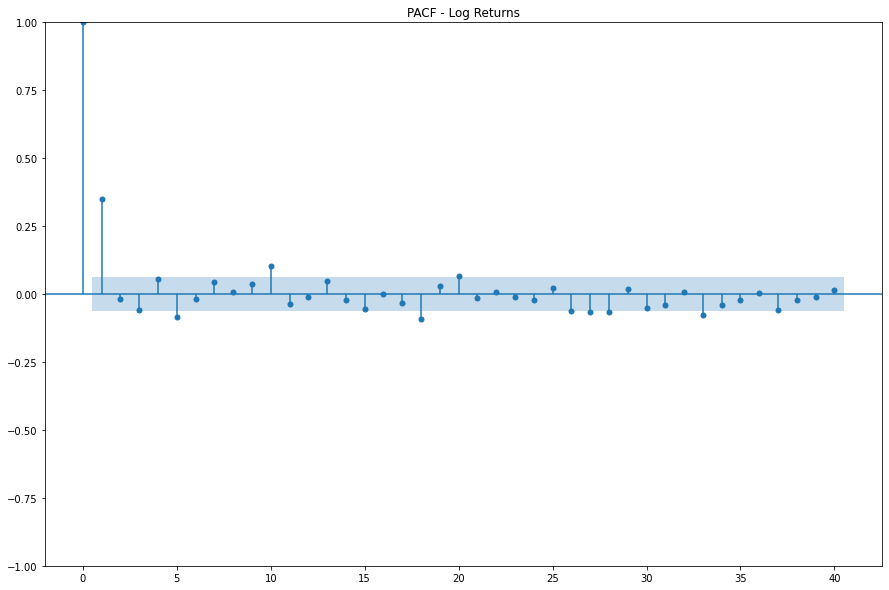

Processing DataFrame for: Usdttmn_Wallex


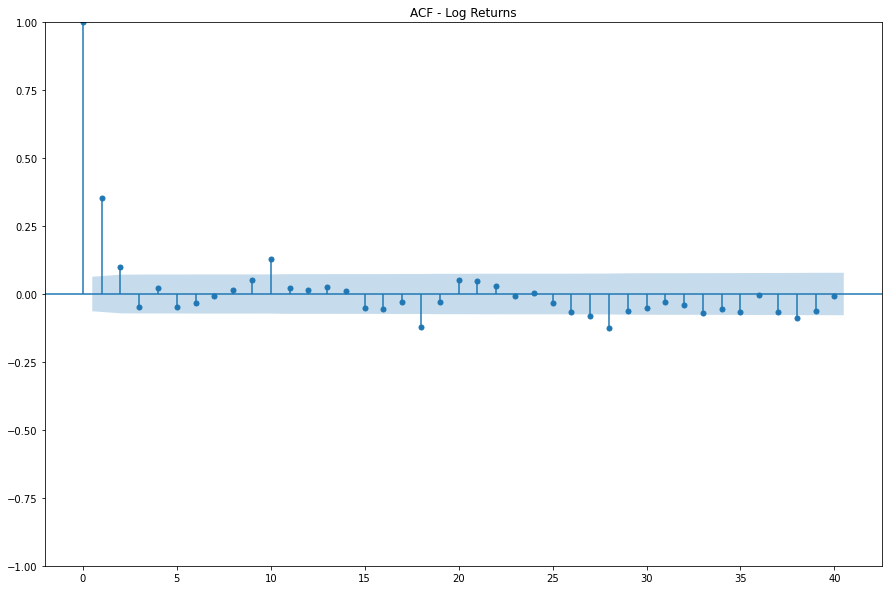

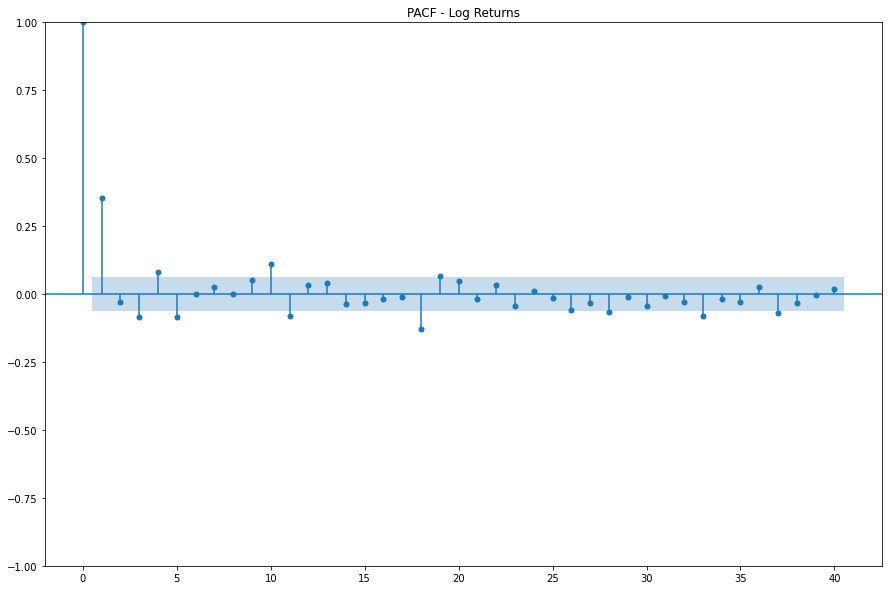

In [248]:
# Assuming 'df' contains your time series data
for key, df in dataframes.items():
    print(f"Processing DataFrame for: {key}")

    plot_acf(df['log_return'].dropna(), lags=40)
    plt.title('ACF - Log Returns')
    plt.show()

    plot_pacf(df['log_return'].dropna(), lags=40)
    plt.title('PACF - Log Returns')
    plt.show()


Autocorrelation and stationarity are essential in time series analysis, especially in financial modeling. ACF and PACF plots help identify temporal dependencies and persistence in market trends, while stationarity tests, like the Augmented Dickey-Fuller (ADF) test, assess the constancy of statistical properties. Non-stationary data often shows autocorrelation, which can mislead forecasting models if not addressed. Transformations, such as differencing, are crucial for making data stationary before modeling. Understanding these properties allows for more accurate predictions and better decision-making in financial markets.


## 2.3 Inter-Market Analysis:
Perform a detailed pairwise cross-correlation analysis of log returns between different USDT-TMN prices.
This pairwise approach provides a nuanced view of market interdependencies and is crucial for comprehensive market analysis. This analysis should be conducted at two levels:
1. Synchronous Correlations: Assess the immediate correlation of log returns across pairs of
USDT-TMN prices (lag 0) using a rolling window of one month. This will highlight concurrent
market movements and potential synchronicity in market reactions.
2. Lagged Correlations: Investigate correlations where one set of returns is lagged by one time
interval (lag 1) using a rolling window of one month. This analysis reveals potential lead-lag
relationships, indicating predictive or reactionary patterns between markets.
3. Application to Strategy: Utilize insights from both synchronous and lagged correlations to
inform trading strategies and risk management. The findings can be instrumental in identifying
arbitrage opportunities and understanding market dynamics for strategic decision-making.


In [249]:
# Calculate rolling correlation for synchronous (lag 0) correlation
def rolling_correlation(df1, df2, window=20):
    return df1['log_return'].rolling(window).corr(df2['log_return'])

In [251]:
# # Example of rolling correlation between df1 and df2 (synchronous)
df1 = dataframes['Usdttmn_Nobitex']
df2 = dataframes['Usdttmn_Tabdeal']
df3 = dataframes['Usdttmn_Wallex']
synchronous_corr_1_2 = rolling_correlation(df1, df2)
synchronous_corr_1_3 = rolling_correlation(df1, df3)
synchronous_corr_2_3 = rolling_correlation(df2, df3)

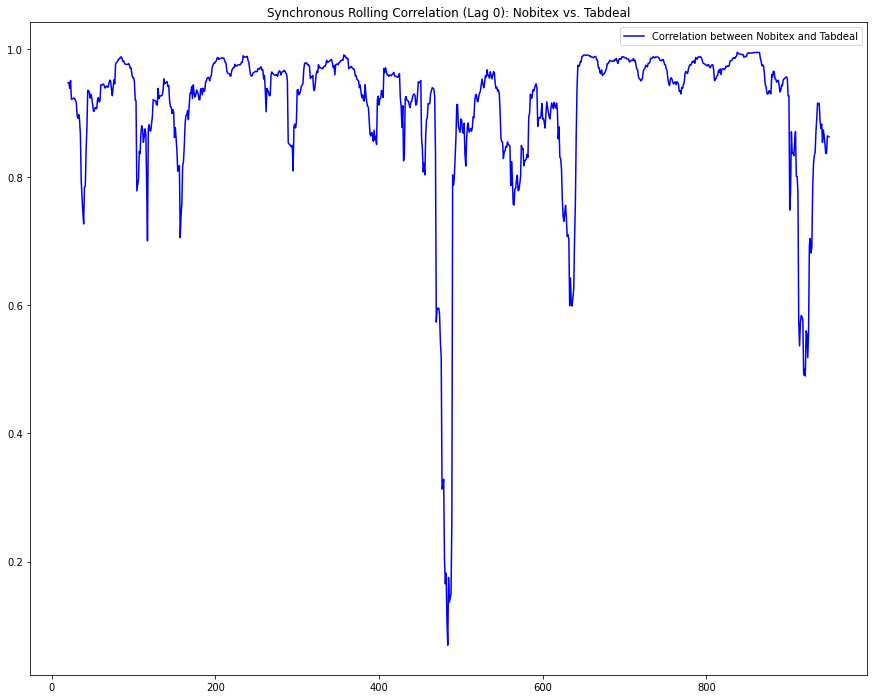

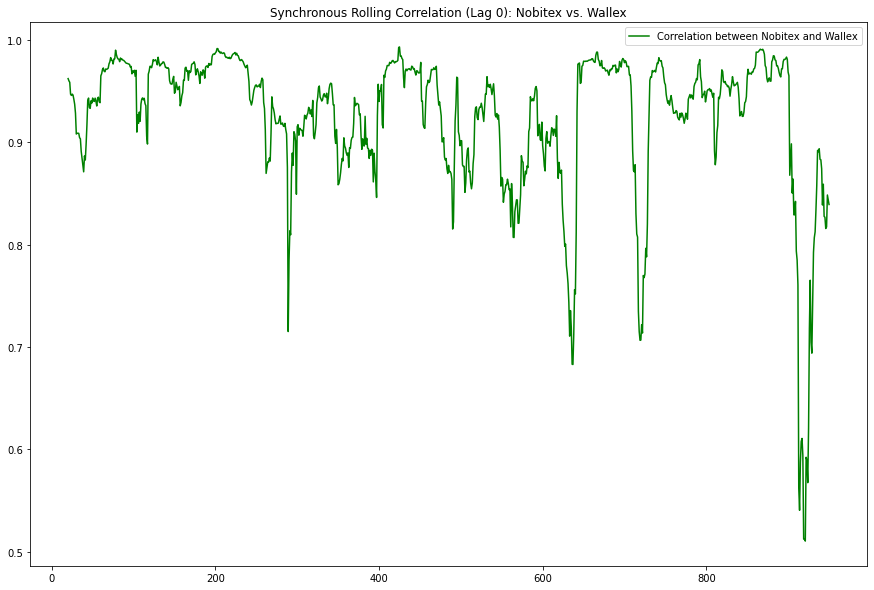

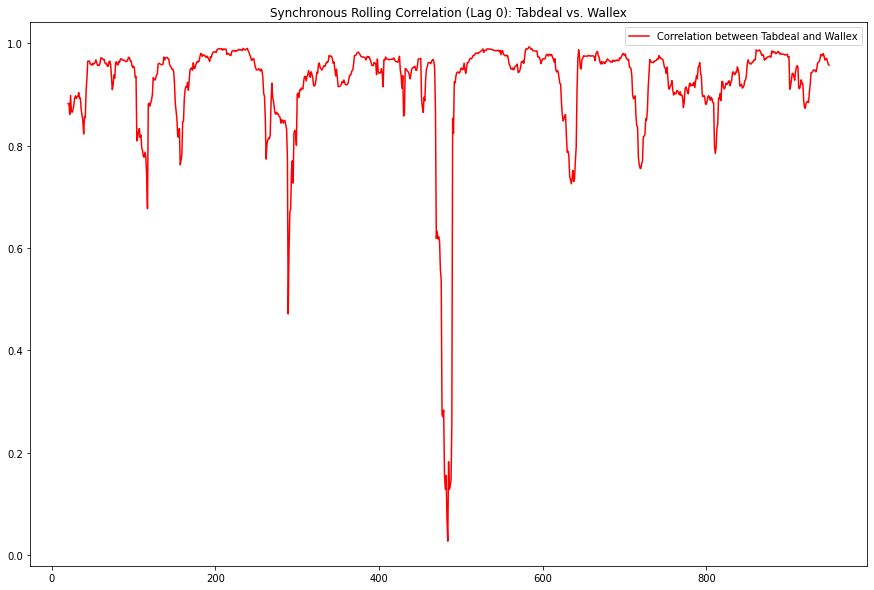

In [254]:
# Plot correlation between Nobitex and Tabdeal
plt.figure(figsize=(15, 12))
plt.plot(synchronous_corr_1_2, label='Correlation between Nobitex and Tabdeal', color='blue')
plt.title('Synchronous Rolling Correlation (Lag 0): Nobitex vs. Tabdeal')
plt.legend()
plt.show()

# Plot correlation between Nobitex and Wallex
plt.plot(synchronous_corr_1_3, label='Correlation between Nobitex and Wallex', color='green')
plt.title('Synchronous Rolling Correlation (Lag 0): Nobitex vs. Wallex')
plt.legend()
plt.show()

# Plot correlation between Tabdeal and Wallex
plt.plot(synchronous_corr_2_3, label='Correlation between Tabdeal and Wallex', color='red')
plt.title('Synchronous Rolling Correlation (Lag 0): Tabdeal vs. Wallex')
plt.legend()
plt.show()


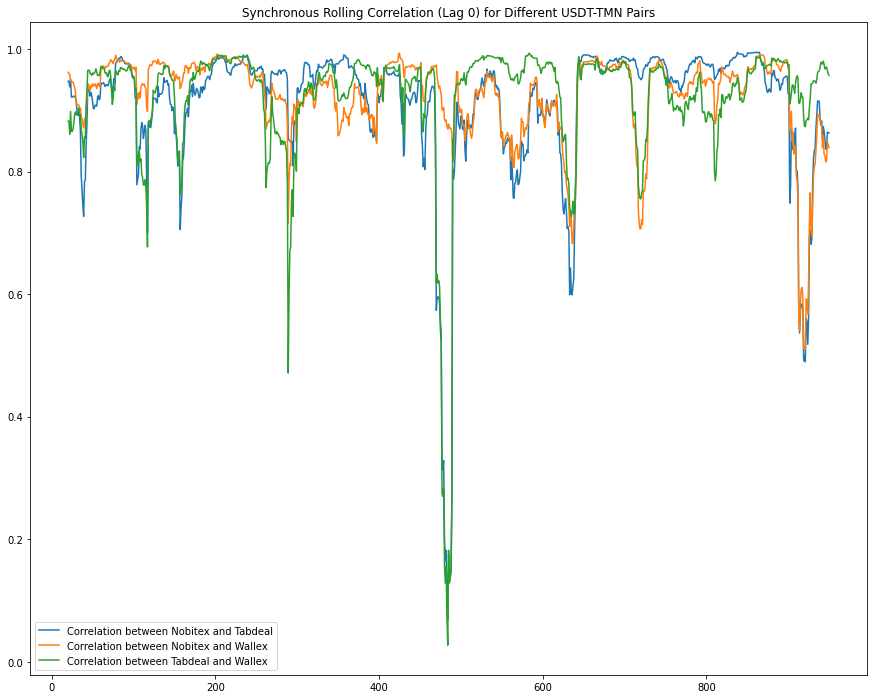

In [255]:
plt.figure(figsize=(15, 12))
plt.plot(synchronous_corr_1_2, label='Correlation between Nobitex and Tabdeal')
plt.plot(synchronous_corr_1_3, label='Correlation between Nobitex and Wallex')
plt.plot(synchronous_corr_2_3, label='Correlation between Tabdeal and Wallex')
plt.title('Synchronous Rolling Correlation (Lag 0) for Different USDT-TMN Pairs')
plt.legend()
plt.show()

In [256]:
# Calculate rolling correlation for lag 1 (shift one series by 1 day)
def rolling_lagged_correlation(df1, df2, window=20, lag=1):
    df2_shifted = df2['log_return'].shift(lag)
    return df1['log_return'].rolling(window).corr(df2_shifted)

In [257]:
# Example of lagged correlation between df1 and df2 (lag 1)
lagged_corr_1_2 = rolling_lagged_correlation(df1, df2)
lagged_corr_1_3 = rolling_lagged_correlation(df1, df3)
lagged_corr_2_3 = rolling_lagged_correlation(df2, df3)

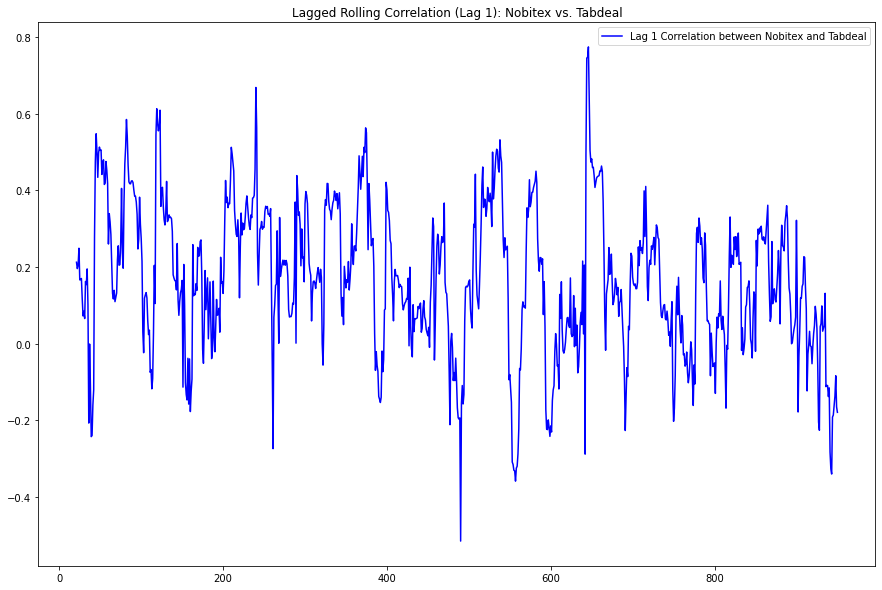

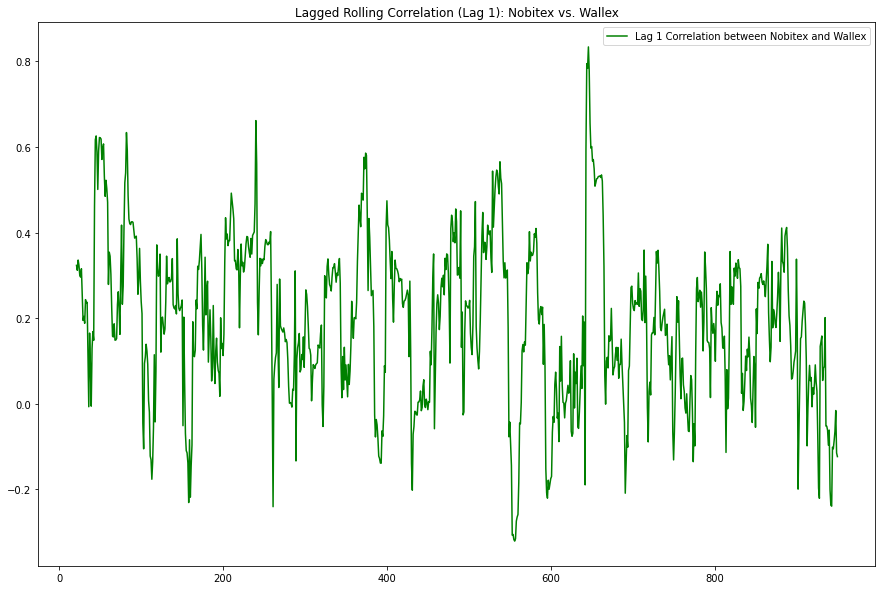

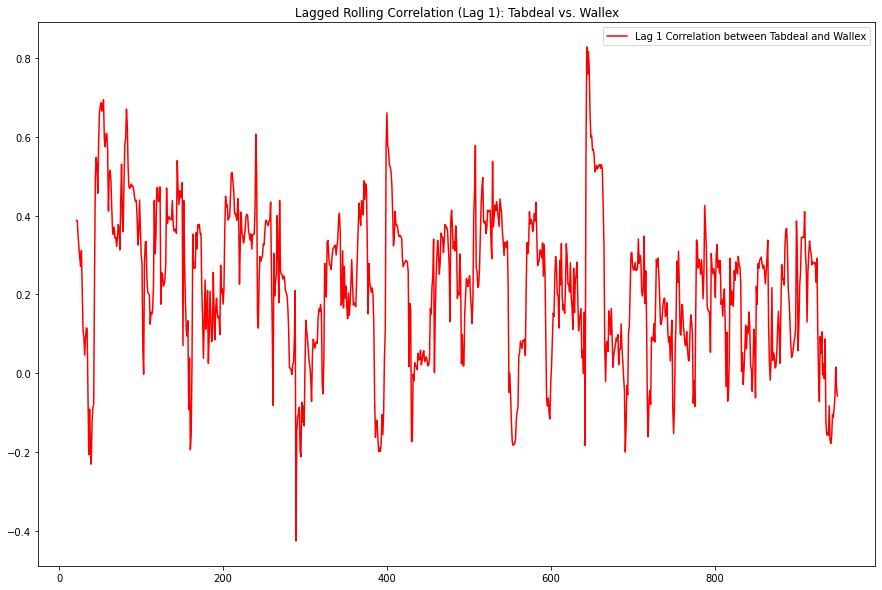

In [259]:
# Plot Lag 1 Correlation between Nobitex and Tabdeal
plt.plot(lagged_corr_1_2, label='Lag 1 Correlation between Nobitex and Tabdeal', color='blue')
plt.title('Lagged Rolling Correlation (Lag 1): Nobitex vs. Tabdeal')
plt.legend()
plt.show()

# Plot Lag 1 Correlation between Nobitex and Wallex
plt.plot(lagged_corr_1_3, label='Lag 1 Correlation between Nobitex and Wallex', color='green')
plt.title('Lagged Rolling Correlation (Lag 1): Nobitex vs. Wallex')
plt.legend()
plt.show()

# Plot Lag 1 Correlation between Tabdeal and Wallex
plt.plot(lagged_corr_2_3, label='Lag 1 Correlation between Tabdeal and Wallex', color='red')
plt.title('Lagged Rolling Correlation (Lag 1): Tabdeal vs. Wallex')
plt.legend()
plt.show()


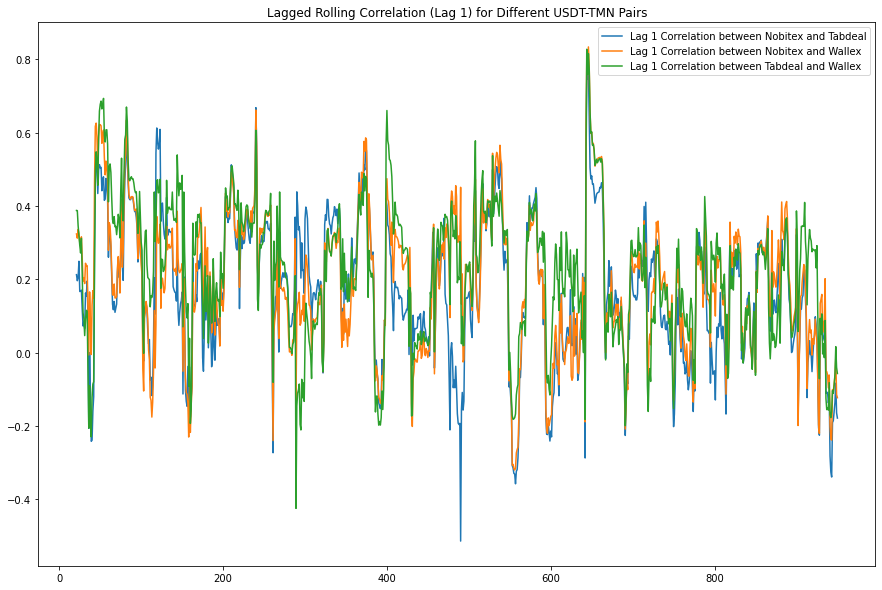

In [258]:
plt.plot(lagged_corr_1_2, label='Lag 1 Correlation between Nobitex and Tabdeal')
plt.plot(lagged_corr_1_3, label='Lag 1 Correlation between Nobitex and Wallex')
plt.plot(lagged_corr_2_3, label='Lag 1 Correlation between Tabdeal and Wallex')
plt.title('Lagged Rolling Correlation (Lag 1) for Different USDT-TMN Pairs')
plt.legend()
plt.show()

##### Step 4: Strategy Insights

- **Synchronous Correlations**: High synchronous correlation means markets move together, useful for pairs trading where you trade opposing directions on two correlated assets. 
- **Lagged Correlations**: If one market lags behind another, it can signal arbitrage oppurtunities, allowing you to predict price changes and act accordingly.

##### Step 5: Summary and Use Cases

- **Arbitrage**: Use lagged correlation to exploit price diferences between markets.  
- **Risk Management**: High correlation shows how risk spreads across markets, helping in better diversification.
- **Predictive Models**: Lagging markets can be forecasted based on leading ones for strategic trading advantages.


# Task 3: Cointegration Analysis:
In this task, you are invited to explore the intricate dynamics of financial time series through cointegration
analysis. Your objective is to assess long-term equilibrium relationships between price series, using
advanced econometric techniques. Remember to refer to the Important Notes outlined at the beginning
of Task 2, as they apply here as well. The methodology (excluding the statistical tests) should be
implemented by yourself.


### 1. Cointegration Testing Methodology:
Execute cointegration tests by selecting either raw prices
or log-transformed prices, justifying your selection based on the inherent characteristics of the
dataset, such as non-stationarity. Consider the statistical properties and practical implications of
each approach. Utilize standard cointegration tests like the Augmented Dickey-Fuller (ADF) test.
Detail the criteria used for test selection and the interpretation of test results in the context of
financial market analysis.

In [264]:
def cointegration_test(series1, series2, key1, key2):
    # Step 1: Regress series1 on series2
    series1 = series1.dropna()
    series2 = series2.dropna()
    regression = sm.OLS(series1, sm.add_constant(series2)).fit()
    residuals = regression.resid

    # Step 2: Perform ADF test on residuals
    adf_result = adfuller(residuals)
    p_value = adf_result[1]

    print(f"Cointegration Test Results:")
    print(f"ADF Statistic: {adf_result[0]}, p-value: {p_value}")

    if p_value < 0.05:
        print(f"The series between {key1} and {key2} are cointegrated.")
    else:
        print("No cointegration detected.")
    print("######################################################")
    return p_value

In [265]:
p_value = cointegration_test(df1['price'], df2['price'], 'Nobitex', 'Tabdeal')
p_value = cointegration_test(df1['price'], df3['price'], 'Nobitex', 'Wallex')
p_value = cointegration_test(df2['price'], df3['price'], 'Tabdeal', 'Wallex')

Cointegration Test Results:
ADF Statistic: -6.6453826842907935, p-value: 5.281746488183638e-09
The series between Nobitex and Tabdeal are cointegrated.
######################################################
Cointegration Test Results:
ADF Statistic: -9.316657418269573, p-value: 1.0148795174898475e-15
The series between Nobitex and Wallex are cointegrated.
######################################################
Cointegration Test Results:
ADF Statistic: -4.782935308388162, p-value: 5.862477375839367e-05
The series between Tabdeal and Wallex are cointegrated.
######################################################


### 2. Dynamic Analysis of Cointegration Parameters:
Split the dataset into monthly segments
and perform cointegration tests on each segment separately. This approach allows you to assess
the stability and evolution of cointegration relationships over time. Focus on analyzing changes in
the cointegration regression coefficients α, β and the stationarity test statistic. Discuss how
these parameters fluctuate and what implications these fluctuations have for understanding market
dynamics and potential arbitrage opportunities.

In [275]:
def dynamic_cointegration_analysis(df1, df2, date_column):
    """
    Perform dynamic cointegration analysis on two dataframes over monthly segments.
    
    Parameters:
    - df1, df2: DataFrames containing 'price' columns and a date index.
    - date_column: The column containing dates, used to ensure proper indexing.

    Returns:
    - results_df: DataFrame containing cointegration results for each monthly segment.
    """

    # Resample to monthly segments using 'ME' (Month-End)
    df1_monthly = df1.resample('ME')
    df2_monthly = df2.resample('ME')

    results = []

    # Use tqdm to track progress
    for month, segment1 in tqdm(df1_monthly, desc="Processing Monthly Segments"):
        if month not in df2_monthly.groups:
            continue

        segment2 = df2_monthly.get_group(month)
        if len(segment1) < 10 or len(segment2) < 10:  # Skip small segments
            continue

        # Perform cointegration regression
        regression = sm.OLS(segment1['price'], sm.add_constant(segment2['price'])).fit()
        residuals = regression.resid
        adf_result = adfuller(residuals)
        p_value = adf_result[1]

        # Store results
        results.append({
            'month': month,
            'alpha': regression.params[0],
            'beta': regression.params[1],
            'adf_statistic': adf_result[0],
            'p_value': p_value,
            'cointegrated': p_value < 0.05
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [277]:
real_df1 = pd.read_csv("usdttmn_m1_nobitex_common_dates_sorted_filtered_sorted.csv")
real_df2 = pd.read_csv("usdttmn_m1_tabdeal_common_dates_sorted_filtered_sorted.csv")
real_df3 = pd.read_csv("usdttmn_m1_wallex_common_dates_sorted_filtered_sorted.csv")

real_df1['date'] = pd.to_datetime(real_df1['date'])
real_df2['date'] = pd.to_datetime(real_df2['date'])
real_df3['date'] = pd.to_datetime(real_df3['date'])

# Set 'date' column as the index
real_df1 = real_df1.set_index('date')
real_df2 = real_df2.set_index('date')
real_df3 = real_df3.set_index('date')

res1 = dynamic_cointegration_analysis(real_df1, real_df2, 'date')
res2 = dynamic_cointegration_analysis(real_df1, real_df3, 'date')
res3 = dynamic_cointegration_analysis(real_df2, real_df3, 'date')

print(res1)
print(res2)
print(res3)

Processing Monthly Segments:   0%|                                                              | 0/17 [00:00<?, ?it/s]C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/13147205.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/13147205.py:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Processing Monthly Segments:   6%|███▏                                                  | 1/17 [00:02<00:38,  2.40s/it]C:\Users\AMIRRE~1\AppData\Local\Temp/ipykernel_12076/13147205.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a futur

        month        alpha      beta  adf_statistic       p_value  \
0  2022-11-30  4675.675651  0.868898      -8.331396  3.361006e-13   
1  2022-12-31   217.100412  0.992484     -13.789431  8.983850e-26   
2  2023-01-31  -466.900473  1.006717     -10.566191  7.506324e-19   
3  2023-02-28   784.750882  0.979065      -8.945416  9.016404e-15   
4  2023-03-31   -52.260750  0.998552     -11.204863  2.197586e-20   
5  2023-04-30  -563.309475  1.007964      -8.415361  2.050688e-13   
6  2023-05-31  1493.972296  0.969565     -10.507909  1.042624e-18   
7  2023-06-30  1123.135396  0.976173     -12.862147  5.083667e-24   
8  2023-07-31  -399.703409  1.006394      -7.619639  2.145451e-11   
9  2023-08-31 -2967.238878  1.059667     -10.183616  6.595872e-18   
10 2023-09-30   -13.987570  0.999755     -11.107429  3.732400e-20   
11 2023-10-31   606.755464  0.988538     -11.351519  9.968062e-21   
12 2023-11-30   362.784793  0.993122      -5.591717  1.324492e-06   
13 2023-12-31  -217.629765  1.0039

# Task 4: Error Correction Model (ECM):
Task 4 focuses on the practical application of an Error Correction Model (ECM) to your previously
identified cointegrated pairs from Task 3. Your challenge is to not only develop an ECM from the ground
up but also to conduct a thorough analysis of its reversion dynamics. This task will test your ability
to implement efficient, bespoke solutions without defaulting to standard libraries, and your insights into
the speed and significance of market corrections. Evaluating the ECM across monthly data segments,
you will gain a deeper understanding of short-term market adjustments and their potential for informing
strategic trading decisions. Remember to refer to the Important Notes outlined at the beginning of
Task 2, as they apply here as well.


### 1. ECM Development:
Construct an ECM for the identified cointegrated pairs from Task 3 interchangeably (2 analysis per pair). Emphasize efficiency in your implementation and avoid relying on
pre-built libraries. Your code should demonstrate an understanding of the underlying econometric
principles and be tailored to the specific dynamics of the financial time series data. Provide a clear
rationale for your modeling choices and the steps involved in the ECM construction.

### 2. Analysis of Reversion Dynamics:
Perform a detailed analysis of the reversion mechanisms
within the ECM, including the significance and the speed at which deviations from equilibrium
are corrected. Split the dataset into monthly segments and apply the ECM to each segment to
observe how these dynamics evolve over time. Discuss the implications of your findings, particularly
in terms of short-term market inefficiencies and potential trading strategies that could exploit these
inefficiencies.


In [278]:
def estimate_cointegration(series1, series2):
    """Estimate cointegration parameters and residuals."""
    X = sm.add_constant(series2)
    model = OLS(series1, X).fit()
    residuals = series1 - model.predict(X)
    return residuals, model.params

In [279]:
def build_ecm(data, series1_name, series2_name):
    """
    Construct an Error Correction Model (ECM) for given series.
    Input:
        data: DataFrame containing 'price', 'price_lagged', 'delta_explanatory', and 'lagged_residual'.
    Output:
        statsmodels OLS model fit.
    """
    explanatory_vars = ['delta_explanatory', 'lagged_residual']
    model = sm.OLS(data['delta_dependent'], sm.add_constant(data[explanatory_vars])).fit()
    return model

In [280]:
def ecm_analysis(df1, df2):
    """
    Perform ECM analysis on two price series.
    """
    # Ensure data alignment
    df1, df2 = df1.copy(), df2.copy()
    df1['price'] = df1['price']
    df2['price'] = df2['price']
    
    # Step 1: Cointegration
    residuals, params = estimate_cointegration(df1['price'], df2['price'])
    print(f"Cointegration Parameters: {params}")
    
    # Add residuals to first DataFrame
    df1['residual'] = residuals
    
    # Step 2: Create lagged variables and deltas
    df1['delta_dependent'] = df1['price'].diff()
    df2['delta_explanatory'] = df2['price'].diff()
    df1['lagged_residual'] = df1['residual'].shift(1)
    
    # Step 3: Split into monthly segments
    df1['month'] = df1.index.to_period('M')
    df2['month'] = df2.index.to_period('M')
    
    monthly_groups = df1.groupby('month')
    results = {}

    # Step 4: Analyze ECM for each month
    for month, group in monthly_groups:
        try:
            # Align explanatory deltas for this month
            explanatory_data = df2.loc[df2['month'] == month, 'delta_explanatory']
            group = group.copy()
            group['delta_explanatory'] = explanatory_data.values
            
            # Drop NaN values
            group = group.dropna(subset=['delta_dependent', 'delta_explanatory', 'lagged_residual'])
            
            # Build ECM
            model = build_ecm(group, 'price', 'price_2')
            results[month] = {
                'gamma': model.params['lagged_residual'],
                'theta': model.params['delta_explanatory'],
                'summary': model.summary()
            }
            print(f"Month: {month}, Gamma: {model.params['lagged_residual']}, Theta: {model.params['delta_explanatory']}")
        except Exception as e:
            print(f"Error for {month}: {e}")
    return results

In [282]:
print('Nobitex, Tabdeal: ')
ecm_analysis(real_df1, real_df2)
print('##########################################')
print()
print('Nobitex, Wallex: ')
ecm_analysis(real_df1, real_df3)
print('##########################################')
print()
print('Tabdeal, Wallex: ')
ecm_analysis(real_df2, real_df3)

Nobitex, Tabdeal: 
Cointegration Parameters: const   -57.286553
price     0.999372
dtype: float64
Month: 2022-11, Gamma: -0.03817927864959115, Theta: 0.03442255863001719
Month: 2022-12, Gamma: -0.02790155929906256, Theta: 0.03362074579602072
Month: 2023-01, Gamma: -0.02582748779522125, Theta: 0.02114928447542415
Month: 2023-02, Gamma: -0.016659771461485853, Theta: 0.10769504439502625
Month: 2023-03, Gamma: -0.02324560324268213, Theta: 0.042302315439223706
Month: 2023-04, Gamma: -0.02239159634132785, Theta: 0.021710799879205628
Month: 2023-05, Gamma: -0.0279148194849766, Theta: 0.01865273771581001
Month: 2023-06, Gamma: -0.03083820563352979, Theta: 0.022590962410483355
Month: 2023-07, Gamma: -0.036182825099102374, Theta: 0.018361222306912107
Month: 2023-08, Gamma: -0.09134807084676506, Theta: 0.04371061401144437
Month: 2023-09, Gamma: -0.17728466696132308, Theta: 0.08241205263466485
Month: 2023-10, Gamma: -0.2288275105887523, Theta: 0.2934327517045042
Month: 2023-11, Gamma: -0.437400506

{Period('2022-11', 'M'): {'gamma': -0.06706401565544483,
  'theta': 0.016200709276519294,
  'summary': <class 'statsmodels.iolib.summary.Summary'>
  """
                              OLS Regression Results                            
  Dep. Variable:        delta_dependent   R-squared:                       0.034
  Model:                            OLS   Adj. R-squared:                  0.034
  Method:                 Least Squares   F-statistic:                     256.4
  Date:                Fri, 10 Jan 2025   Prob (F-statistic):          3.78e-110
  Time:                        01:28:59   Log-Likelihood:                -70815.
  No. Observations:               14405   AIC:                         1.416e+05
  Df Residuals:                   14402   BIC:                         1.417e+05
  Df Model:                           2                                         
  Covariance Type:            nonrobust                                         
                          coef    std